# Skeleton Threat Detection

In [1]:
import time
import numpy as np
import tensorflow as tf
from os import listdir
from os.path import isfile, join
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold

# Notebook auto reloads code. (Ref: http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython)
%load_ext autoreload
%autoreload 2

# Part 1: Load Data

In [2]:
# set relevant skeletal indexes in the desired order with labels. Create array for skeletons with confidence flag
rele_dexes = [12,11,10,2,13,14,15,3,7,-1]
joint_names = ['R Shoulder','R Elbow','R Wrist','R Hip','L Shoulder','L Elbow','L Hand','L Hip','Neck','Gun']
conf_flag = 1   # should be 0 or 1
x = np.empty((1,len(rele_dexes),2+conf_flag))
y = []

# set indexes for normalization 
right_elbow = 8
right_wrist = 10
l_shoulder = 5
r_shoulder = 6

#set folders and labels for each folder (0=high,1=medium,2=low)
folders = ["skeleton_threat/1_high/skeletons/", "skeleton_threat/2_medium/skeletons/", "skeleton_threat/3_mild/skeletons/", "skeleton_threat/4_low/skeletons/"]
threats = [0,1,2,2]

#read skeletons into array and create labels
last_count = 0
for folder in range(len(folders)):
    for f in listdir(folders[folder]):
        skele = np.load(folders[folder]+f)    #read skeletons
        skele[-1][-1] = 1  #reset gun confidence which is always 0 in given files
        if skele[rele_dexes].all() > .0001:     #only include skeletons with all joints
            skele[:,0:2] -= skele[right_elbow,0:2]     #normalize to right elbow with elbow to wrist=1
            forearm_len = np.sqrt(skele[right_wrist][0]**2+skele[right_wrist][1]**2)
            skele[:,0:2] /= forearm_len
            skele[0] = (skele[l_shoulder] + skele[r_shoulder])/2   #calculate chest index for skeletal comparison
            x = np.vstack((x,np.expand_dims(skele[rele_dexes,0:2+conf_flag],axis=0))) #add to input array
    y = np.concatenate((y,[threats[folder]]*(x.shape[0]-last_count)))   #add labels to label list
    last_count = x.shape[0]
                    
x_flat = x.reshape([x.shape[0],x.shape[1]*x.shape[2]]) #flatten for neural network input

#checks for sizes
print(x.shape)
print(y.shape)
print(x[-1])

(1671, 10, 3)
(1671,)
[[-0.28883209  0.14097757  0.89813292]
 [-0.43668662  0.54327941  0.88740748]
 [-0.41949423  0.907758    0.87686896]
 [-0.14785452  0.9834045   0.74616951]
 [ 0.28195514  0.14097757  0.88743639]
 [ 0.44356357  0.52608702  0.88704264]
 [ 0.44356357  0.90088105  0.87294561]
 [ 0.19255473  0.97652755  0.7159431 ]
 [ 0.00343848  0.14097757  0.46307075]
 [-0.33181306  0.80116521  1.        ]]


In [3]:
# create one hot label array from labels
oh_y = np.array(y,dtype=np.int64)
num_labels = len(np.unique(oh_y))
oh_y = np.eye(num_labels)[oh_y]

# columns: x, y, confidence

# Create and Train Model

In [4]:
from feedforward_model import *

In [5]:
# set splits for k-folds and create empty array
splits = 10
kf = KFold(n_splits=splits, shuffle=True, random_state=1)
conf_mat = np.empty((splits,num_labels,num_labels))

# train models for each split and save to an array
i = 0
for train_index, test_index in kf.split(x_flat):
    x_train, x_test = x_flat[train_index], x_flat[test_index]   #create train and test sets
    y_train, y_test = oh_y[train_index], oh_y[test_index]
    
    # create and train model
    model = feedforward(x_flat.shape[1],num_labels,hidden_layer_size=[8],learning_rate=.0025,train_keep_prob=[.5])
    model.train(x_train,y_train,x_test,y_test,epochs=30,batch_size=64)
    conf_mat[i] = confusion_matrix(y[test_index],model.predict(x_test)[0])  #add confusion matrix to array
    i += 1

Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use keras.layers.dropout instead.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.

number of batches for training: 23
0.02242875099182129
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 65.47619047619048%
epoch 3
epoch 4
epoch 5
epoch 6
epoch 7
Best validation accuracy! iteration:150 accuracy: 67.85714285714286%
epoch 8
Best validation accuracy! iteration:175 accuracy: 72.02380952380952%
epoch 9
Best validation accuracy! iteration:200 accuracy: 73.21428571428571%
epoch 10
Best validation accuracy! iteration:225 accuracy: 75.0%
epoch 11
Best validation accuracy! iteration:250 accuracy: 76.78571428571429%
epoch 12
Best validation accuracy! iteration:275 accuracy: 78.5714285714

number of batches for training: 23
0.01732182502746582
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 50.29940119760479%
epoch 3
Best validation accuracy! iteration:50 accuracy: 53.293413173652695%
epoch 4
epoch 5
Best validation accuracy! iteration:100 accuracy: 62.27544910179641%
epoch 6
Best validation accuracy! iteration:125 accuracy: 69.46107784431138%
epoch 7
Best validation accuracy! iteration:150 accuracy: 71.8562874251497%
epoch 8
Best validation accuracy! iteration:175 accuracy: 73.05389221556887%
epoch 9
Best validation accuracy! iteration:200 accuracy: 74.25149700598801%
epoch 10
Best validation accuracy! iteration:225 accuracy: 76.64670658682635%
epoch 11
Best validation accuracy! iteration:250 accuracy: 79.04191616766467%
epoch 12
epoch 13
epoch 14
Best validation accuracy! iteration:300 accuracy: 80.83832335329342%
epoch 15
epoch 16
Best validation accuracy! iteration:350 accuracy: 81.437125748503%
epoch 17
epoch 18
epoch 19
Best validation accuracy! it

[[754.  60.  11.]
 [ 77. 182.  91.]
 [ 24.  27. 445.]]
mean
[[75.4  6.   1.1]
 [ 7.7 18.2  9.1]
 [ 2.4  2.7 44.5]]
std
[[4.36348485 2.40831892 0.7       ]
 [2.05182845 2.63818119 1.92093727]
 [1.56204994 1.61554944 4.96487663]]
82.64512268102932
0.42590552600019355
7.116881339463234


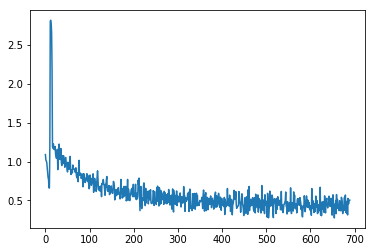

In [6]:
# plot loss, total classifications, mean over splits, and std over splits
model.plot()
print(sum(conf_mat))
print("mean")
print(np.mean(conf_mat,axis=0))
print("std")
print(np.std(conf_mat,axis=0))

#create accuracy (sum of diagonal dividied by total classified)
mat = sum(conf_mat)
diag = sum(np.diagonal(mat))
print(diag/sum(sum(mat))*100)

#find and print standard deviations
stds = np.std(conf_mat,axis=0)
var = 0
for i in range(conf_mat.shape[1]):
    var += stds[i,i]**2
print(np.sqrt(var)/sum(sum(mat))*100)
print(np.sqrt(var))

In [7]:
#give a prediction example
labels = np.array(['High','Med','Low'])
test = np.reshape(x_test[0],(1,len(x_test[0])))
prediction = model.predict(test)
print("Predicted label is ", labels[prediction[0][0]])
tested_y = np.ndarray.astype(y_test[0],bool)
print("Actual label is ",labels[tested_y][0])

INFO:tensorflow:Restoring parameters from model/basic_model
Predicted label is  High
Actual label is  High


In [8]:
# find and print mean and totals in LaTeX code
mean = np.mean(conf_mat,axis=0)
totals_b = np.sum(mean,axis=0)
totals_r = np.sum(mean,axis=1)
total = np.sum(totals_r)
print(end='\\rota{Actual}')
for i in range(mean.shape[0]):
    print(" & {0:s} & {1:.1f} & {2:.1f} & {3:.1f} & {4:.1f} \\\\".format(labels[i],mean[i,0],mean[i,1],mean[i,2],totals_r[i]))
print('\\toprule')
print(" & Totals & {0:.1f} & {1:.1f} & {2:.1f} & {3:.1f}".format(totals_b[0],totals_b[1],totals_b[2],total))

\rota{Actual} & High & 75.4 & 6.0 & 1.1 & 82.5 \\
 & Med & 7.7 & 18.2 & 9.1 & 35.0 \\
 & Low & 2.4 & 2.7 & 44.5 & 49.6 \\
\toprule
 & Totals & 85.5 & 26.9 & 54.7 & 167.1


In [9]:
#create new confusion matrix
conf_mat = np.empty((x.shape[1],splits,num_labels,num_labels))

#remove each joint from input and retrain with k-folds
for i in range(x.shape[1]):
    print(i)
    sub_x = np.delete(x,i,1)
    sub_x = sub_x.reshape([sub_x.shape[0],sub_x.shape[1]*sub_x.shape[2]])
    j = 0
    for train_index, test_index in kf.split(sub_x):
        x_train, x_test = sub_x[train_index], sub_x[test_index]
        y_train, y_test = oh_y[train_index], oh_y[test_index]
        model = feedforward(sub_x.shape[1],num_labels,hidden_layer_size=[8],learning_rate=.0025,train_keep_prob=[.5])
        model.train(x_train,y_train,x_test,y_test,epochs=30,batch_size=64)
        conf_mat[i,j] = confusion_matrix(y[test_index],model.predict(x_test)[0])
        j += 1

0
number of batches for training: 23
0.01889634132385254
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 22.61904761904762%
epoch 3
Best validation accuracy! iteration:50 accuracy: 32.73809523809524%
epoch 4
Best validation accuracy! iteration:75 accuracy: 45.83333333333333%
epoch 5
Best validation accuracy! iteration:100 accuracy: 50.0%
epoch 6
Best validation accuracy! iteration:125 accuracy: 53.57142857142857%
epoch 7
Best validation accuracy! iteration:150 accuracy: 62.5%
epoch 8
Best validation accuracy! iteration:175 accuracy: 67.85714285714286%
epoch 9
Best validation accuracy! iteration:200 accuracy: 69.64285714285714%
epoch 10
Best validation accuracy! iteration:225 accuracy: 73.21428571428571%
epoch 11
epoch 12
Best validation accuracy! iteration:275 accuracy: 73.80952380952381%
epoch 13
epoch 14
Best validation accuracy! iteration:300 accuracy: 74.40476190476191%
epoch 15
epoch 16
epoch 17
Best validation accuracy! iteration:375 accuracy: 75.59523809523809%


epoch 26
epoch 27
Best validation accuracy! iteration:600 accuracy: 85.02994011976048%
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 85.02994011976048. Model named basic_model.
INFO:tensorflow:Restoring parameters from model/basic_model
number of batches for training: 23
0.016860008239746094
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 47.30538922155689%
epoch 3
Best validation accuracy! iteration:50 accuracy: 53.293413173652695%
epoch 4
Best validation accuracy! iteration:75 accuracy: 66.46706586826348%
epoch 5
Best validation accuracy! iteration:100 accuracy: 72.45508982035929%
epoch 6
epoch 7
epoch 8
epoch 9
epoch 10
epoch 11
epoch 12
Best validation accuracy! iteration:275 accuracy: 73.05389221556887%
epoch 13
epoch 14
Best validation accuracy! iteration:300 accuracy: 74.25149700598801%
epoch 15
epoch 16
epoch 17
epoch 18
epoch 19
epoch 20
epoch 21
epoch 22
Best validation accuracy! iteration:500 accuracy: 74.8502994011976%
epoch 23
epoch 2

epoch 2
Best validation accuracy! iteration:25 accuracy: 52.09580838323353%
epoch 3
epoch 4
Best validation accuracy! iteration:75 accuracy: 57.48502994011976%
epoch 5
Best validation accuracy! iteration:100 accuracy: 65.26946107784431%
epoch 6
Best validation accuracy! iteration:125 accuracy: 70.65868263473054%
epoch 7
epoch 8
Best validation accuracy! iteration:175 accuracy: 72.45508982035929%
epoch 9
Best validation accuracy! iteration:200 accuracy: 73.05389221556887%
epoch 10
Best validation accuracy! iteration:225 accuracy: 74.8502994011976%
epoch 11
Best validation accuracy! iteration:250 accuracy: 77.24550898203593%
epoch 12
Best validation accuracy! iteration:275 accuracy: 77.84431137724552%
epoch 13
epoch 14
epoch 15
epoch 16
epoch 17
epoch 18
Best validation accuracy! iteration:400 accuracy: 79.64071856287424%
epoch 19
Best validation accuracy! iteration:425 accuracy: 80.83832335329342%
epoch 20
epoch 21
epoch 22
epoch 23
epoch 24
epoch 25
Best validation accuracy! iteration:

epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
Best validation accuracy! iteration:675 accuracy: 79.64071856287424%
Traning ends. The best valid accuracy is 79.64071856287424. Model named basic_model.
INFO:tensorflow:Restoring parameters from model/basic_model
number of batches for training: 23
0.019966602325439453
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 59.2814371257485%
epoch 3
Best validation accuracy! iteration:50 accuracy: 69.46107784431138%
epoch 4
Best validation accuracy! iteration:75 accuracy: 70.05988023952095%
epoch 5
epoch 6
Best validation accuracy! iteration:125 accuracy: 72.45508982035929%
epoch 7
Best validation accuracy! iteration:150 accuracy: 74.8502994011976%
epoch 8
Best validation accuracy! iteration:175 accuracy: 76.04790419161677%
epoch 9
Best validation accuracy! iteration:200 accuracy: 77.24550898203593%
epoch 10
Best validation accuracy! iteration:225 accuracy: 77.84431137724552%
epoch 11
Best validation accuracy! iteration:250

epoch 21
epoch 22
epoch 23
epoch 24
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 80.23952095808383. Model named basic_model.
INFO:tensorflow:Restoring parameters from model/basic_model
number of batches for training: 23
0.02000284194946289
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 46.10778443113773%
epoch 3
Best validation accuracy! iteration:50 accuracy: 48.50299401197605%
epoch 4
Best validation accuracy! iteration:75 accuracy: 50.29940119760479%
epoch 5
epoch 6
Best validation accuracy! iteration:125 accuracy: 56.287425149700596%
epoch 7
Best validation accuracy! iteration:150 accuracy: 61.07784431137725%
epoch 8
Best validation accuracy! iteration:175 accuracy: 70.05988023952095%
epoch 9
Best validation accuracy! iteration:200 accuracy: 73.65269461077844%
epoch 10
Best validation accuracy! iteration:225 accuracy: 75.44910179640718%
epoch 11
epoch 12
Best validation accuracy! iteration:275 accuracy: 77.84431137

epoch 30
Best validation accuracy! iteration:675 accuracy: 84.52380952380952%
Traning ends. The best valid accuracy is 84.52380952380952. Model named basic_model.
INFO:tensorflow:Restoring parameters from model/basic_model
number of batches for training: 23
0.02030038833618164
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 39.52095808383233%
epoch 3
Best validation accuracy! iteration:50 accuracy: 52.09580838323353%
epoch 4
Best validation accuracy! iteration:75 accuracy: 53.89221556886228%
epoch 5
Best validation accuracy! iteration:100 accuracy: 54.49101796407185%
epoch 6
Best validation accuracy! iteration:125 accuracy: 57.48502994011976%
epoch 7
Best validation accuracy! iteration:150 accuracy: 60.47904191616767%
epoch 8
Best validation accuracy! iteration:175 accuracy: 66.46706586826348%
epoch 9
Best validation accuracy! iteration:200 accuracy: 70.05988023952095%
epoch 10
Best validation accuracy! iteration:225 accuracy: 73.65269461077844%
epoch 11
epoch 12
Best 

epoch 10
Best validation accuracy! iteration:225 accuracy: 76.64670658682635%
epoch 11
Best validation accuracy! iteration:250 accuracy: 77.24550898203593%
epoch 12
Best validation accuracy! iteration:275 accuracy: 79.64071856287424%
epoch 13
epoch 14
Best validation accuracy! iteration:300 accuracy: 80.83832335329342%
epoch 15
epoch 16
epoch 17
epoch 18
epoch 19
Best validation accuracy! iteration:425 accuracy: 82.03592814371258%
epoch 20
epoch 21
epoch 22
epoch 23
epoch 24
epoch 25
Best validation accuracy! iteration:575 accuracy: 82.63473053892216%
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 82.63473053892216. Model named basic_model.
INFO:tensorflow:Restoring parameters from model/basic_model
number of batches for training: 23
0.020661115646362305
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 47.30538922155689%
epoch 3
Best validation accuracy! iteration:50 accuracy: 59.88023952095808%
epoch 4
Best validation accuracy! it

number of batches for training: 23
0.018573999404907227
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 47.90419161676647%
epoch 3
Best validation accuracy! iteration:50 accuracy: 70.65868263473054%
epoch 4
Best validation accuracy! iteration:75 accuracy: 74.8502994011976%
epoch 5
Best validation accuracy! iteration:100 accuracy: 76.64670658682635%
epoch 6
epoch 7
epoch 8
Best validation accuracy! iteration:175 accuracy: 78.44311377245509%
epoch 9
Best validation accuracy! iteration:200 accuracy: 79.64071856287424%
epoch 10
epoch 11
Best validation accuracy! iteration:250 accuracy: 80.23952095808383%
epoch 12
epoch 13
epoch 14
epoch 15
Best validation accuracy! iteration:325 accuracy: 81.437125748503%
epoch 16
Best validation accuracy! iteration:350 accuracy: 82.03592814371258%
epoch 17
Best validation accuracy! iteration:375 accuracy: 82.63473053892216%
epoch 18
epoch 19
Best validation accuracy! iteration:425 accuracy: 83.23353293413174%
epoch 20
Best validation accu

epoch 9
Best validation accuracy! iteration:200 accuracy: 69.46107784431138%
epoch 10
Best validation accuracy! iteration:225 accuracy: 72.45508982035929%
epoch 11
Best validation accuracy! iteration:250 accuracy: 74.25149700598801%
epoch 12
epoch 13
epoch 14
Best validation accuracy! iteration:300 accuracy: 75.44910179640718%
epoch 15
Best validation accuracy! iteration:325 accuracy: 77.84431137724552%
epoch 16
epoch 17
Best validation accuracy! iteration:375 accuracy: 78.44311377245509%
epoch 18
epoch 19
Best validation accuracy! iteration:425 accuracy: 79.04191616766467%
epoch 20
Best validation accuracy! iteration:450 accuracy: 80.23952095808383%
epoch 21
epoch 22
epoch 23
epoch 24
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 80.23952095808383. Model named basic_model.
INFO:tensorflow:Restoring parameters from model/basic_model
number of batches for training: 23
0.016721010208129883
epoch 1
epoch 2
Best validation accuracy! iteratio

epoch 10
Best validation accuracy! iteration:225 accuracy: 76.04790419161677%
epoch 11
epoch 12
Best validation accuracy! iteration:275 accuracy: 77.24550898203593%
epoch 13
epoch 14
Best validation accuracy! iteration:300 accuracy: 77.84431137724552%
epoch 15
epoch 16
epoch 17
epoch 18
epoch 19
Best validation accuracy! iteration:425 accuracy: 78.44311377245509%
epoch 20
epoch 21
Best validation accuracy! iteration:475 accuracy: 80.83832335329342%
epoch 22
epoch 23
epoch 24
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
Best validation accuracy! iteration:650 accuracy: 81.437125748503%
epoch 30
Traning ends. The best valid accuracy is 81.437125748503. Model named basic_model.
INFO:tensorflow:Restoring parameters from model/basic_model
number of batches for training: 23
0.016579627990722656
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 58.08383233532935%
epoch 3
Best validation accuracy! iteration:50 accuracy: 62.27544910179641%
epoch 4
Best validation accuracy! iterat

epoch 2
Best validation accuracy! iteration:25 accuracy: 45.23809523809524%
epoch 3
epoch 4
Best validation accuracy! iteration:75 accuracy: 50.595238095238095%
epoch 5
Best validation accuracy! iteration:100 accuracy: 60.11904761904761%
epoch 6
Best validation accuracy! iteration:125 accuracy: 63.69047619047619%
epoch 7
Best validation accuracy! iteration:150 accuracy: 64.28571428571429%
epoch 8
Best validation accuracy! iteration:175 accuracy: 66.66666666666666%
epoch 9
Best validation accuracy! iteration:200 accuracy: 67.85714285714286%
epoch 10
Best validation accuracy! iteration:225 accuracy: 70.83333333333334%
epoch 11
Best validation accuracy! iteration:250 accuracy: 71.42857142857143%
epoch 12
Best validation accuracy! iteration:275 accuracy: 72.61904761904762%
epoch 13
epoch 14
Best validation accuracy! iteration:300 accuracy: 74.40476190476191%
epoch 15
Best validation accuracy! iteration:325 accuracy: 75.59523809523809%
epoch 16
epoch 17
Best validation accuracy! iteration:3

Best validation accuracy! iteration:525 accuracy: 80.83832335329342%
epoch 24
Best validation accuracy! iteration:550 accuracy: 81.437125748503%
epoch 25
Best validation accuracy! iteration:575 accuracy: 82.63473053892216%
epoch 26
epoch 27
Best validation accuracy! iteration:600 accuracy: 83.8323353293413%
epoch 28
Best validation accuracy! iteration:625 accuracy: 85.62874251497006%
epoch 29
epoch 30
Best validation accuracy! iteration:675 accuracy: 86.82634730538922%
Traning ends. The best valid accuracy is 86.82634730538922. Model named basic_model.
INFO:tensorflow:Restoring parameters from model/basic_model
number of batches for training: 23
0.01676630973815918
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 48.50299401197605%
epoch 3
Best validation accuracy! iteration:50 accuracy: 52.69461077844312%
epoch 4
Best validation accuracy! iteration:75 accuracy: 68.26347305389223%
epoch 5
Best validation accuracy! iteration:100 accuracy: 70.05988023952095%
epoch 6
Best 

epoch 23
epoch 24
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
Best validation accuracy! iteration:650 accuracy: 82.03592814371258%
epoch 30
Traning ends. The best valid accuracy is 82.03592814371258. Model named basic_model.
INFO:tensorflow:Restoring parameters from model/basic_model
number of batches for training: 23
0.016820430755615234
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 49.700598802395206%
epoch 3
Best validation accuracy! iteration:50 accuracy: 51.49700598802395%
epoch 4
Best validation accuracy! iteration:75 accuracy: 58.68263473053892%
epoch 5
Best validation accuracy! iteration:100 accuracy: 64.67065868263472%
epoch 6
Best validation accuracy! iteration:125 accuracy: 71.25748502994011%
epoch 7
Best validation accuracy! iteration:150 accuracy: 74.8502994011976%
epoch 8
Best validation accuracy! iteration:175 accuracy: 76.64670658682635%
epoch 9
Best validation accuracy! iteration:200 accuracy: 77.24550898203593%
epoch 10
Best validation accuracy! it

epoch 10
epoch 11
Best validation accuracy! iteration:250 accuracy: 76.64670658682635%
epoch 12
Best validation accuracy! iteration:275 accuracy: 77.24550898203593%
epoch 13
epoch 14
Best validation accuracy! iteration:300 accuracy: 78.44311377245509%
epoch 15
Best validation accuracy! iteration:325 accuracy: 80.83832335329342%
epoch 16
epoch 17
Best validation accuracy! iteration:375 accuracy: 82.63473053892216%
epoch 18
epoch 19
epoch 20
epoch 21
Best validation accuracy! iteration:475 accuracy: 84.4311377245509%
epoch 22
epoch 23
epoch 24
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 84.4311377245509. Model named basic_model.
INFO:tensorflow:Restoring parameters from model/basic_model
number of batches for training: 23
0.016744613647460938
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 25.149700598802394%
epoch 3
Best validation accuracy! iteration:50 accuracy: 48.50299401197605%
epoch 4
Best validation accuracy! ite

epoch 22
epoch 23
epoch 24
Best validation accuracy! iteration:550 accuracy: 80.83832335329342%
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
Best validation accuracy! iteration:675 accuracy: 81.437125748503%
Traning ends. The best valid accuracy is 81.437125748503. Model named basic_model.
INFO:tensorflow:Restoring parameters from model/basic_model
number of batches for training: 23
0.01657891273498535
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 45.50898203592814%
epoch 3
Best validation accuracy! iteration:50 accuracy: 59.88023952095808%
epoch 4
Best validation accuracy! iteration:75 accuracy: 62.874251497005986%
epoch 5
Best validation accuracy! iteration:100 accuracy: 65.86826347305389%
epoch 6
Best validation accuracy! iteration:125 accuracy: 67.66467065868264%
epoch 7
epoch 8
epoch 9
epoch 10
Best validation accuracy! iteration:225 accuracy: 68.26347305389223%
epoch 11
Best validation accuracy! iteration:250 accuracy: 68.8622754491018%
epoch 12
Best v

epoch 21
Best validation accuracy! iteration:475 accuracy: 78.44311377245509%
epoch 22
epoch 23
Best validation accuracy! iteration:525 accuracy: 79.04191616766467%
epoch 24
epoch 25
Best validation accuracy! iteration:575 accuracy: 80.23952095808383%
epoch 26
epoch 27
epoch 28
epoch 29
Best validation accuracy! iteration:650 accuracy: 81.437125748503%
epoch 30
Best validation accuracy! iteration:675 accuracy: 82.03592814371258%
Traning ends. The best valid accuracy is 82.03592814371258. Model named basic_model.
INFO:tensorflow:Restoring parameters from model/basic_model
9
number of batches for training: 23
0.017071247100830078
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 45.23809523809524%
epoch 3
Best validation accuracy! iteration:50 accuracy: 51.78571428571429%
epoch 4
Best validation accuracy! iteration:75 accuracy: 60.71428571428571%
epoch 5
Best validation accuracy! iteration:100 accuracy: 64.88095238095238%
epoch 6
epoch 7
Best validation accuracy! iteration

epoch 22
epoch 23
epoch 24
Best validation accuracy! iteration:550 accuracy: 80.83832335329342%
epoch 25
epoch 26
epoch 27
epoch 28
Best validation accuracy! iteration:625 accuracy: 82.03592814371258%
epoch 29
epoch 30
Traning ends. The best valid accuracy is 82.03592814371258. Model named basic_model.
INFO:tensorflow:Restoring parameters from model/basic_model
number of batches for training: 23
0.016722440719604492
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 39.52095808383233%
epoch 3
Best validation accuracy! iteration:50 accuracy: 47.90419161676647%
epoch 4
Best validation accuracy! iteration:75 accuracy: 50.898203592814376%
epoch 5
Best validation accuracy! iteration:100 accuracy: 53.293413173652695%
epoch 6
epoch 7
Best validation accuracy! iteration:150 accuracy: 55.08982035928144%
epoch 8
Best validation accuracy! iteration:175 accuracy: 62.27544910179641%
epoch 9
Best validation accuracy! iteration:200 accuracy: 64.67065868263472%
epoch 10
Best validation a

In [10]:
# print sums, means, and stds
for i in range(conf_mat.shape[0]):
    print(joint_names[i])
    print(sum(conf_mat[i]))
print("mean")
print(np.mean(conf_mat,axis=0))
print("std")
print(np.std(conf_mat,axis=0))

R Shoulder
[[750.  59.  16.]
 [ 78. 174.  98.]
 [ 30.  21. 445.]]
R Elbow
[[754.  53.  18.]
 [ 91. 162.  97.]
 [ 24.  23. 449.]]
R Wrist
[[767.  47.  11.]
 [ 90. 167.  93.]
 [ 32.  25. 439.]]
R Hip
[[752.  59.  14.]
 [ 75. 179.  96.]
 [ 25.  20. 451.]]
L Shoulder
[[764.  47.  14.]
 [ 81. 180.  89.]
 [ 32.  17. 447.]]
L Elbow
[[758.  52.  15.]
 [ 73. 187.  90.]
 [ 30.  22. 444.]]
L Hand
[[767.  48.  10.]
 [ 80. 176.  94.]
 [ 31.  22. 443.]]
L Hip
[[762.  49.  14.]
 [ 81. 182.  87.]
 [ 26.  28. 442.]]
Neck
[[766.  41.  18.]
 [ 91. 167.  92.]
 [ 29.  30. 437.]]
Gun
[[746.  44.  35.]
 [ 73. 146. 131.]
 [ 48.  32. 416.]]
mean
[[[73.5  2.9  1.6]
  [ 8.7 19.6 10.7]
  [ 3.3  3.4 44.3]]

 [[79.6  5.4  1. ]
  [ 4.  16.9 10.1]
  [ 6.5  2.4 41.1]]

 [[74.7  5.2  4.1]
  [ 6.4 17.8 10.8]
  [ 2.2  0.5 45.3]]

 [[81.1  6.2  1.7]
  [ 7.1 16.4 11.5]
  [ 1.2  4.1 37.7]]

 [[74.   3.5  1.5]
  [12.  13.4 11.6]
  [ 3.5  1.7 45.8]]

 [[77.8  5.9  1.3]
  [10.  18.3  7.7]
  [ 0.3  0.8 44.9]]

 [[79.8  7.9  1.3

In [11]:
# set variables for mean, variance, and sum values
m = 0
v = 0
s = 0

#for each joint, calculate accuracy %, mean, and std
for i in range(conf_mat.shape[0]):
    print(joint_names[i])
    mat = sum(conf_mat[i])
    diag = sum(np.diagonal(mat))
    print(diag/sum(sum(mat))*100)
    m += diag/sum(sum(mat))*100
    stds = np.std(conf_mat[i],axis=0)
    var = 0
    for j in range(stds.shape[1]):
        var += stds[j,j]**2
    v += var
    s += sum(sum(mat))
    
print(1)
print(m/(conf_mat.shape[0]-1))
print(np.sqrt(v)/s*100)

R Shoulder
81.92698982645122
R Elbow
81.68761220825853
R Wrist
82.16636744464392
R Hip
82.7049670855775
L Shoulder
83.24356672651108
L Elbow
83.12387791741472
L Hand
82.9443447037702
L Hip
82.9443447037702
Neck
81.9868342309994
Gun
78.27648114901257
1
91.22282066626771
0.13034682814874252


In [12]:
# create empty confusion matrix
conf_mat = np.empty((x.shape[1],x.shape[1],splits,num_labels,num_labels))

#remove two joints and retrain network with k-folds
for i in range(x.shape[1]):
    for j in range(i,x.shape[1]):
        sub_x = np.delete(x,[i,j],1)
        sub_x = sub_x.reshape([sub_x.shape[0],sub_x.shape[1]*sub_x.shape[2]])
        k = 0
        for train_index, test_index in kf.split(sub_x):
            x_train, x_test = sub_x[train_index], sub_x[test_index]
            y_train, y_test = oh_y[train_index], oh_y[test_index]
            model = feedforward(sub_x.shape[1],num_labels,hidden_layer_size=[8],learning_rate=.0025,train_keep_prob=[.5])
            model.train(x_train,y_train,x_test,y_test,epochs=30,batch_size=64,model_name="model")
            conf_mat[i,j,k] = confusion_matrix(y[test_index],model.predict(x_test)[0])
            k+= 1

number of batches for training: 23
0.017450571060180664
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 41.66666666666667%
epoch 3
Best validation accuracy! iteration:50 accuracy: 63.095238095238095%
epoch 4
Best validation accuracy! iteration:75 accuracy: 66.07142857142857%
epoch 5
epoch 6
epoch 7
epoch 8
Best validation accuracy! iteration:175 accuracy: 68.45238095238095%
epoch 9
epoch 10
Best validation accuracy! iteration:225 accuracy: 70.23809523809523%
epoch 11
Best validation accuracy! iteration:250 accuracy: 72.61904761904762%
epoch 12
Best validation accuracy! iteration:275 accuracy: 73.21428571428571%
epoch 13
epoch 14
Best validation accuracy! iteration:300 accuracy: 75.0%
epoch 15
epoch 16
epoch 17
epoch 18
Best validation accuracy! iteration:400 accuracy: 76.19047619047619%
epoch 19
epoch 20
epoch 21
Best validation accuracy! iteration:475 accuracy: 78.57142857142857%
epoch 22
epoch 23
epoch 24
epoch 25
Best validation accuracy! iteration:575 accuracy: 79.

number of batches for training: 23
0.016809701919555664
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 54.49101796407185%
epoch 3
Best validation accuracy! iteration:50 accuracy: 63.47305389221557%
epoch 4
Best validation accuracy! iteration:75 accuracy: 68.26347305389223%
epoch 5
epoch 6
epoch 7
Best validation accuracy! iteration:150 accuracy: 68.8622754491018%
epoch 8
Best validation accuracy! iteration:175 accuracy: 71.8562874251497%
epoch 9
Best validation accuracy! iteration:200 accuracy: 72.45508982035929%
epoch 10
Best validation accuracy! iteration:225 accuracy: 76.64670658682635%
epoch 11
epoch 12
Best validation accuracy! iteration:275 accuracy: 78.44311377245509%
epoch 13
epoch 14
epoch 15
epoch 16
epoch 17
epoch 18
epoch 19
epoch 20
Best validation accuracy! iteration:450 accuracy: 79.64071856287424%
epoch 21
epoch 22
Best validation accuracy! iteration:500 accuracy: 80.83832335329342%
epoch 23
Best validation accuracy! iteration:525 accuracy: 82.03592814

epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
Best validation accuracy! iteration:675 accuracy: 83.23353293413174%
Traning ends. The best valid accuracy is 83.23353293413174. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 23
0.016765832901000977
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 50.898203592814376%
epoch 3
epoch 4
Best validation accuracy! iteration:75 accuracy: 53.293413173652695%
epoch 5
Best validation accuracy! iteration:100 accuracy: 62.874251497005986%
epoch 6
Best validation accuracy! iteration:125 accuracy: 65.26946107784431%
epoch 7
Best validation accuracy! iteration:150 accuracy: 65.86826347305389%
epoch 8
Best validation accuracy! iteration:175 accuracy: 67.66467065868264%
epoch 9
Best validation accuracy! iteration:200 accuracy: 70.65868263473054%
epoch 10
Best validation accuracy! iteration:225 accuracy: 73.05389221556887%
epoch 11
Best validation accuracy! iteration:250 accuracy: 73.6

epoch 10
Best validation accuracy! iteration:225 accuracy: 69.46107784431138%
epoch 11
Best validation accuracy! iteration:250 accuracy: 71.8562874251497%
epoch 12
Best validation accuracy! iteration:275 accuracy: 74.25149700598801%
epoch 13
epoch 14
Best validation accuracy! iteration:300 accuracy: 76.04790419161677%
epoch 15
Best validation accuracy! iteration:325 accuracy: 77.84431137724552%
epoch 16
Best validation accuracy! iteration:350 accuracy: 79.04191616766467%
epoch 17
epoch 18
epoch 19
epoch 20
epoch 21
epoch 22
Best validation accuracy! iteration:500 accuracy: 79.64071856287424%
epoch 23
epoch 24
Best validation accuracy! iteration:550 accuracy: 80.23952095808383%
epoch 25
epoch 26
epoch 27
epoch 28
Best validation accuracy! iteration:625 accuracy: 81.437125748503%
epoch 29
epoch 30
Traning ends. The best valid accuracy is 81.437125748503. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 23
0.016649484634399414
epoch 

number of batches for training: 23
0.0167539119720459
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 31.736526946107784%
epoch 3
Best validation accuracy! iteration:50 accuracy: 40.7185628742515%
epoch 4
Best validation accuracy! iteration:75 accuracy: 51.49700598802395%
epoch 5
Best validation accuracy! iteration:100 accuracy: 55.08982035928144%
epoch 6
Best validation accuracy! iteration:125 accuracy: 71.8562874251497%
epoch 7
Best validation accuracy! iteration:150 accuracy: 72.45508982035929%
epoch 8
Best validation accuracy! iteration:175 accuracy: 74.25149700598801%
epoch 9
Best validation accuracy! iteration:200 accuracy: 74.8502994011976%
epoch 10
Best validation accuracy! iteration:225 accuracy: 76.64670658682635%
epoch 11
Best validation accuracy! iteration:250 accuracy: 80.23952095808383%
epoch 12
Best validation accuracy! iteration:275 accuracy: 80.83832335329342%
epoch 13
epoch 14
Best validation accuracy! iteration:300 accuracy: 82.03592814371258%
epoch 

epoch 7
Best validation accuracy! iteration:150 accuracy: 60.47904191616767%
epoch 8
Best validation accuracy! iteration:175 accuracy: 67.06586826347305%
epoch 9
Best validation accuracy! iteration:200 accuracy: 71.25748502994011%
epoch 10
Best validation accuracy! iteration:225 accuracy: 71.8562874251497%
epoch 11
epoch 12
epoch 13
epoch 14
epoch 15
Best validation accuracy! iteration:325 accuracy: 73.05389221556887%
epoch 16
Best validation accuracy! iteration:350 accuracy: 74.8502994011976%
epoch 17
Best validation accuracy! iteration:375 accuracy: 76.04790419161677%
epoch 18
Best validation accuracy! iteration:400 accuracy: 76.64670658682635%
epoch 19
Best validation accuracy! iteration:425 accuracy: 77.24550898203593%
epoch 20
epoch 21
epoch 22
epoch 23
epoch 24
epoch 25
Best validation accuracy! iteration:575 accuracy: 78.44311377245509%
epoch 26
epoch 27
Best validation accuracy! iteration:600 accuracy: 79.04191616766467%
epoch 28
Best validation accuracy! iteration:625 accuracy

number of batches for training: 23
0.01666545867919922
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 45.50898203592814%
epoch 3
Best validation accuracy! iteration:50 accuracy: 46.706586826347305%
epoch 4
Best validation accuracy! iteration:75 accuracy: 54.49101796407185%
epoch 5
Best validation accuracy! iteration:100 accuracy: 62.874251497005986%
epoch 6
Best validation accuracy! iteration:125 accuracy: 71.8562874251497%
epoch 7
Best validation accuracy! iteration:150 accuracy: 73.05389221556887%
epoch 8
Best validation accuracy! iteration:175 accuracy: 74.25149700598801%
epoch 9
epoch 10
Best validation accuracy! iteration:225 accuracy: 74.8502994011976%
epoch 11
epoch 12
Best validation accuracy! iteration:275 accuracy: 76.04790419161677%
epoch 13
epoch 14
Best validation accuracy! iteration:300 accuracy: 77.84431137724552%
epoch 15
Best validation accuracy! iteration:325 accuracy: 79.04191616766467%
epoch 16
Best validation accuracy! iteration:350 accuracy: 79.6

epoch 24
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
Best validation accuracy! iteration:675 accuracy: 82.63473053892216%
Traning ends. The best valid accuracy is 82.63473053892216. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 23
0.016906023025512695
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 24.550898203592812%
epoch 3
Best validation accuracy! iteration:50 accuracy: 38.92215568862276%
epoch 4
Best validation accuracy! iteration:75 accuracy: 62.27544910179641%
epoch 5
Best validation accuracy! iteration:100 accuracy: 68.26347305389223%
epoch 6
Best validation accuracy! iteration:125 accuracy: 68.8622754491018%
epoch 7
Best validation accuracy! iteration:150 accuracy: 71.25748502994011%
epoch 8
epoch 9
Best validation accuracy! iteration:200 accuracy: 72.45508982035929%
epoch 10
Best validation accuracy! iteration:225 accuracy: 77.24550898203593%
epoch 11
epoch 12
Best validation accuracy! itera

number of batches for training: 23
0.021518945693969727
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 36.52694610778443%
epoch 3
Best validation accuracy! iteration:50 accuracy: 52.69461077844312%
epoch 4
Best validation accuracy! iteration:75 accuracy: 57.48502994011976%
epoch 5
Best validation accuracy! iteration:100 accuracy: 62.27544910179641%
epoch 6
Best validation accuracy! iteration:125 accuracy: 71.8562874251497%
epoch 7
Best validation accuracy! iteration:150 accuracy: 74.8502994011976%
epoch 8
epoch 9
epoch 10
epoch 11
epoch 12
Best validation accuracy! iteration:275 accuracy: 77.24550898203593%
epoch 13
epoch 14
Best validation accuracy! iteration:300 accuracy: 78.44311377245509%
epoch 15
Best validation accuracy! iteration:325 accuracy: 79.04191616766467%
epoch 16
epoch 17
Best validation accuracy! iteration:375 accuracy: 80.83832335329342%
epoch 18
epoch 19
epoch 20
epoch 21
epoch 22
Best validation accuracy! iteration:500 accuracy: 81.437125748503%
epo

epoch 19
epoch 20
epoch 21
epoch 22
epoch 23
epoch 24
epoch 25
epoch 26
epoch 27
epoch 28
Best validation accuracy! iteration:625 accuracy: 80.83832335329342%
epoch 29
epoch 30
Traning ends. The best valid accuracy is 80.83832335329342. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 23
0.016659975051879883
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 51.49700598802395%
epoch 3
Best validation accuracy! iteration:50 accuracy: 52.09580838323353%
epoch 4
Best validation accuracy! iteration:75 accuracy: 66.46706586826348%
epoch 5
Best validation accuracy! iteration:100 accuracy: 70.65868263473054%
epoch 6
epoch 7
Best validation accuracy! iteration:150 accuracy: 72.45508982035929%
epoch 8
Best validation accuracy! iteration:175 accuracy: 73.05389221556887%
epoch 9
epoch 10
Best validation accuracy! iteration:225 accuracy: 74.25149700598801%
epoch 11
Best validation accuracy! iteration:250 accuracy: 77.24550898203

epoch 22
Best validation accuracy! iteration:500 accuracy: 79.76190476190477%
epoch 23
epoch 24
epoch 25
Best validation accuracy! iteration:575 accuracy: 80.35714285714286%
epoch 26
epoch 27
epoch 28
Best validation accuracy! iteration:625 accuracy: 82.14285714285714%
epoch 29
epoch 30
Traning ends. The best valid accuracy is 82.14285714285714. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 23
0.016828298568725586
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 52.69461077844312%
epoch 3
Best validation accuracy! iteration:50 accuracy: 56.287425149700596%
epoch 4
Best validation accuracy! iteration:75 accuracy: 61.07784431137725%
epoch 5
Best validation accuracy! iteration:100 accuracy: 64.07185628742515%
epoch 6
Best validation accuracy! iteration:125 accuracy: 69.46107784431138%
epoch 7
Best validation accuracy! iteration:150 accuracy: 70.65868263473054%
epoch 8
Best validation accuracy! iteration:175 accurac

epoch 9
Best validation accuracy! iteration:200 accuracy: 74.25149700598801%
epoch 10
epoch 11
Best validation accuracy! iteration:250 accuracy: 75.44910179640718%
epoch 12
epoch 13
epoch 14
epoch 15
epoch 16
Best validation accuracy! iteration:350 accuracy: 77.24550898203593%
epoch 17
epoch 18
Best validation accuracy! iteration:400 accuracy: 77.84431137724552%
epoch 19
epoch 20
Best validation accuracy! iteration:450 accuracy: 78.44311377245509%
epoch 21
epoch 22
epoch 23
Best validation accuracy! iteration:525 accuracy: 79.04191616766467%
epoch 24
epoch 25
epoch 26
epoch 27
epoch 28
Best validation accuracy! iteration:625 accuracy: 79.64071856287424%
epoch 29
epoch 30
Traning ends. The best valid accuracy is 79.64071856287424. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 23
0.01669931411743164
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 50.29940119760479%
epoch 3
epoch 4
Best validation accuracy! iterat

epoch 11
Best validation accuracy! iteration:250 accuracy: 77.24550898203593%
epoch 12
Best validation accuracy! iteration:275 accuracy: 77.84431137724552%
epoch 13
epoch 14
Best validation accuracy! iteration:300 accuracy: 79.64071856287424%
epoch 15
epoch 16
Best validation accuracy! iteration:350 accuracy: 80.83832335329342%
epoch 17
Best validation accuracy! iteration:375 accuracy: 82.03592814371258%
epoch 18
epoch 19
epoch 20
epoch 21
epoch 22
epoch 23
Best validation accuracy! iteration:525 accuracy: 83.23353293413174%
epoch 24
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 83.23353293413174. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 23
0.021787166595458984
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 41.91616766467065%
epoch 3
epoch 4
Best validation accuracy! iteration:75 accuracy: 59.2814371257485%
epoch 5
Best validation accuracy! iteration:100 ac

epoch 9
Best validation accuracy! iteration:200 accuracy: 77.84431137724552%
epoch 10
Best validation accuracy! iteration:225 accuracy: 79.64071856287424%
epoch 11
epoch 12
Best validation accuracy! iteration:275 accuracy: 80.23952095808383%
epoch 13
epoch 14
epoch 15
epoch 16
Best validation accuracy! iteration:350 accuracy: 80.83832335329342%
epoch 17
epoch 18
epoch 19
epoch 20
epoch 21
epoch 22
epoch 23
Best validation accuracy! iteration:525 accuracy: 81.437125748503%
epoch 24
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 81.437125748503. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 23
0.01974177360534668
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 45.50898203592814%
epoch 3
Best validation accuracy! iteration:50 accuracy: 46.10778443113773%
epoch 4
epoch 5
Best validation accuracy! iteration:100 accuracy: 72.45508982035929%
epoch 6
Best validation accur

epoch 26
epoch 27
epoch 28
Best validation accuracy! iteration:625 accuracy: 81.437125748503%
epoch 29
epoch 30
Best validation accuracy! iteration:675 accuracy: 82.03592814371258%
Traning ends. The best valid accuracy is 82.03592814371258. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 23
0.017210006713867188
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 39.52095808383233%
epoch 3
Best validation accuracy! iteration:50 accuracy: 40.7185628742515%
epoch 4
Best validation accuracy! iteration:75 accuracy: 57.48502994011976%
epoch 5
Best validation accuracy! iteration:100 accuracy: 63.47305389221557%
epoch 6
Best validation accuracy! iteration:125 accuracy: 65.86826347305389%
epoch 7
Best validation accuracy! iteration:150 accuracy: 71.8562874251497%
epoch 8
Best validation accuracy! iteration:175 accuracy: 74.25149700598801%
epoch 9
Best validation accuracy! iteration:200 accuracy: 74.8502994011976%
epoch 10
Bes

epoch 25
epoch 26
epoch 27
Best validation accuracy! iteration:600 accuracy: 73.80952380952381%
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 73.80952380952381. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 23
0.016600608825683594
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 46.706586826347305%
epoch 3
Best validation accuracy! iteration:50 accuracy: 56.886227544910184%
epoch 4
Best validation accuracy! iteration:75 accuracy: 60.47904191616767%
epoch 5
Best validation accuracy! iteration:100 accuracy: 70.05988023952095%
epoch 6
epoch 7
Best validation accuracy! iteration:150 accuracy: 72.45508982035929%
epoch 8
epoch 9
epoch 10
Best validation accuracy! iteration:225 accuracy: 75.44910179640718%
epoch 11
epoch 12
epoch 13
epoch 14
epoch 15
Best validation accuracy! iteration:325 accuracy: 76.04790419161677%
epoch 16
epoch 17
epoch 18
epoch 19
Best validation accuracy! iteration:425 accu

number of batches for training: 23
0.017014741897583008
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 29.34131736526946%
epoch 3
Best validation accuracy! iteration:50 accuracy: 41.91616766467065%
epoch 4
Best validation accuracy! iteration:75 accuracy: 61.07784431137725%
epoch 5
Best validation accuracy! iteration:100 accuracy: 64.67065868263472%
epoch 6
Best validation accuracy! iteration:125 accuracy: 68.26347305389223%
epoch 7
Best validation accuracy! iteration:150 accuracy: 71.8562874251497%
epoch 8
epoch 9
epoch 10
Best validation accuracy! iteration:225 accuracy: 72.45508982035929%
epoch 11
Best validation accuracy! iteration:250 accuracy: 73.65269461077844%
epoch 12
Best validation accuracy! iteration:275 accuracy: 74.25149700598801%
epoch 13
epoch 14
Best validation accuracy! iteration:300 accuracy: 76.64670658682635%
epoch 15
Best validation accuracy! iteration:325 accuracy: 77.84431137724552%
epoch 16
Best validation accuracy! iteration:350 accuracy: 79.0

number of batches for training: 23
0.021755218505859375
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 46.706586826347305%
epoch 3
Best validation accuracy! iteration:50 accuracy: 56.287425149700596%
epoch 4
Best validation accuracy! iteration:75 accuracy: 65.86826347305389%
epoch 5
Best validation accuracy! iteration:100 accuracy: 68.8622754491018%
epoch 6
Best validation accuracy! iteration:125 accuracy: 70.05988023952095%
epoch 7
Best validation accuracy! iteration:150 accuracy: 71.25748502994011%
epoch 8
Best validation accuracy! iteration:175 accuracy: 73.65269461077844%
epoch 9
Best validation accuracy! iteration:200 accuracy: 74.8502994011976%
epoch 10
Best validation accuracy! iteration:225 accuracy: 75.44910179640718%
epoch 11
epoch 12
Best validation accuracy! iteration:275 accuracy: 77.24550898203593%
epoch 13
epoch 14
Best validation accuracy! iteration:300 accuracy: 78.44311377245509%
epoch 15
Best validation accuracy! iteration:325 accuracy: 79.041916167

number of batches for training: 23
0.021214008331298828
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 44.91017964071856%
epoch 3
epoch 4
Best validation accuracy! iteration:75 accuracy: 55.08982035928144%
epoch 5
Best validation accuracy! iteration:100 accuracy: 64.67065868263472%
epoch 6
Best validation accuracy! iteration:125 accuracy: 70.65868263473054%
epoch 7
Best validation accuracy! iteration:150 accuracy: 74.25149700598801%
epoch 8
Best validation accuracy! iteration:175 accuracy: 76.04790419161677%
epoch 9
Best validation accuracy! iteration:200 accuracy: 78.44311377245509%
epoch 10
Best validation accuracy! iteration:225 accuracy: 79.04191616766467%
epoch 11
Best validation accuracy! iteration:250 accuracy: 79.64071856287424%
epoch 12
Best validation accuracy! iteration:275 accuracy: 80.23952095808383%
epoch 13
epoch 14
Best validation accuracy! iteration:300 accuracy: 81.437125748503%
epoch 15
epoch 16
epoch 17
epoch 18
Best validation accuracy! iteration:

epoch 13
epoch 14
epoch 15
Best validation accuracy! iteration:325 accuracy: 75.44910179640718%
epoch 16
epoch 17
Best validation accuracy! iteration:375 accuracy: 76.64670658682635%
epoch 18
epoch 19
epoch 20
epoch 21
epoch 22
Best validation accuracy! iteration:500 accuracy: 77.24550898203593%
epoch 23
Best validation accuracy! iteration:525 accuracy: 77.84431137724552%
epoch 24
Best validation accuracy! iteration:550 accuracy: 78.44311377245509%
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
Best validation accuracy! iteration:650 accuracy: 80.23952095808383%
epoch 30
Traning ends. The best valid accuracy is 80.23952095808383. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 23
0.01659679412841797
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 38.92215568862276%
epoch 3
Best validation accuracy! iteration:50 accuracy: 45.50898203592814%
epoch 4
Best validation accuracy! iteration:75 accuracy: 56.287425149700596%

epoch 29
epoch 30
Traning ends. The best valid accuracy is 79.64071856287424. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 23
0.016567707061767578
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 71.25748502994011%
epoch 3
Best validation accuracy! iteration:50 accuracy: 73.05389221556887%
epoch 4
Best validation accuracy! iteration:75 accuracy: 73.65269461077844%
epoch 5
Best validation accuracy! iteration:100 accuracy: 74.25149700598801%
epoch 6
Best validation accuracy! iteration:125 accuracy: 76.04790419161677%
epoch 7
Best validation accuracy! iteration:150 accuracy: 77.84431137724552%
epoch 8
epoch 9
Best validation accuracy! iteration:200 accuracy: 78.44311377245509%
epoch 10
epoch 11
Best validation accuracy! iteration:250 accuracy: 79.64071856287424%
epoch 12
Best validation accuracy! iteration:275 accuracy: 80.23952095808383%
epoch 13
epoch 14
Best validation accuracy! iteration:300 accuracy: 81.43712

epoch 10
epoch 11
epoch 12
Best validation accuracy! iteration:275 accuracy: 78.44311377245509%
epoch 13
epoch 14
Best validation accuracy! iteration:300 accuracy: 80.23952095808383%
epoch 15
epoch 16
epoch 17
epoch 18
epoch 19
epoch 20
epoch 21
epoch 22
epoch 23
Best validation accuracy! iteration:525 accuracy: 80.83832335329342%
epoch 24
epoch 25
Best validation accuracy! iteration:575 accuracy: 82.03592814371258%
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 82.03592814371258. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 23
0.016814470291137695
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 20.958083832335326%
epoch 3
Best validation accuracy! iteration:50 accuracy: 22.15568862275449%
epoch 4
Best validation accuracy! iteration:75 accuracy: 31.736526946107784%
epoch 5
Best validation accuracy! iteration:100 accuracy: 46.10778443113773%
epoch 6
Best validation accurac

epoch 10
Best validation accuracy! iteration:225 accuracy: 71.25748502994011%
epoch 11
Best validation accuracy! iteration:250 accuracy: 73.05389221556887%
epoch 12
epoch 13
epoch 14
epoch 15
epoch 16
Best validation accuracy! iteration:350 accuracy: 74.25149700598801%
epoch 17
epoch 18
Best validation accuracy! iteration:400 accuracy: 75.44910179640718%
epoch 19
epoch 20
Best validation accuracy! iteration:450 accuracy: 77.84431137724552%
epoch 21
Best validation accuracy! iteration:475 accuracy: 79.04191616766467%
epoch 22
epoch 23
Best validation accuracy! iteration:525 accuracy: 80.23952095808383%
epoch 24
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 80.23952095808383. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 23
0.0167691707611084
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 49.101796407185624%
epoch 3
Best validation accuracy! iteration:50 accuracy:

Best validation accuracy! iteration:250 accuracy: 69.04761904761905%
epoch 12
Best validation accuracy! iteration:275 accuracy: 70.23809523809523%
epoch 13
epoch 14
Best validation accuracy! iteration:300 accuracy: 71.42857142857143%
epoch 15
Best validation accuracy! iteration:325 accuracy: 72.02380952380952%
epoch 16
Best validation accuracy! iteration:350 accuracy: 73.80952380952381%
epoch 17
epoch 18
epoch 19
Best validation accuracy! iteration:425 accuracy: 77.97619047619048%
epoch 20
epoch 21
Best validation accuracy! iteration:475 accuracy: 78.57142857142857%
epoch 22
epoch 23
Best validation accuracy! iteration:525 accuracy: 79.16666666666666%
epoch 24
Best validation accuracy! iteration:550 accuracy: 79.76190476190477%
epoch 25
epoch 26
epoch 27
Best validation accuracy! iteration:600 accuracy: 81.54761904761905%
epoch 28
epoch 29
epoch 30
Best validation accuracy! iteration:675 accuracy: 82.14285714285714%
Traning ends. The best valid accuracy is 82.14285714285714. Model name

epoch 30
Traning ends. The best valid accuracy is 77.84431137724552. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 23
0.017028093338012695
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 46.706586826347305%
epoch 3
Best validation accuracy! iteration:50 accuracy: 48.50299401197605%
epoch 4
Best validation accuracy! iteration:75 accuracy: 59.2814371257485%
epoch 5
Best validation accuracy! iteration:100 accuracy: 65.26946107784431%
epoch 6
Best validation accuracy! iteration:125 accuracy: 68.26347305389223%
epoch 7
Best validation accuracy! iteration:150 accuracy: 69.46107784431138%
epoch 8
Best validation accuracy! iteration:175 accuracy: 70.05988023952095%
epoch 9
Best validation accuracy! iteration:200 accuracy: 70.65868263473054%
epoch 10
Best validation accuracy! iteration:225 accuracy: 71.8562874251497%
epoch 11
epoch 12
epoch 13
epoch 14
Best validation accuracy! iteration:300 accuracy: 72.45508982035929%

Traning ends. The best valid accuracy is 83.23353293413174. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 23
0.0166933536529541
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 26.94610778443114%
epoch 3
Best validation accuracy! iteration:50 accuracy: 44.31137724550898%
epoch 4
Best validation accuracy! iteration:75 accuracy: 64.67065868263472%
epoch 5
Best validation accuracy! iteration:100 accuracy: 70.05988023952095%
epoch 6
Best validation accuracy! iteration:125 accuracy: 73.65269461077844%
epoch 7
Best validation accuracy! iteration:150 accuracy: 74.8502994011976%
epoch 8
epoch 9
epoch 10
epoch 11
epoch 12
epoch 13
epoch 14
epoch 15
Best validation accuracy! iteration:325 accuracy: 75.44910179640718%
epoch 16
epoch 17
epoch 18
epoch 19
Best validation accuracy! iteration:425 accuracy: 76.04790419161677%
epoch 20
Best validation accuracy! iteration:450 accuracy: 77.24550898203593%
epoch 21
Best validation 

epoch 21
epoch 22
epoch 23
Best validation accuracy! iteration:525 accuracy: 79.64071856287424%
epoch 24
Best validation accuracy! iteration:550 accuracy: 80.83832335329342%
epoch 25
epoch 26
epoch 27
epoch 28
Best validation accuracy! iteration:625 accuracy: 82.03592814371258%
epoch 29
Best validation accuracy! iteration:650 accuracy: 83.23353293413174%
epoch 30
Traning ends. The best valid accuracy is 83.23353293413174. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 23
0.016669034957885742
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 44.642857142857146%
epoch 3
Best validation accuracy! iteration:50 accuracy: 45.83333333333333%
epoch 4
Best validation accuracy! iteration:75 accuracy: 47.61904761904761%
epoch 5
Best validation accuracy! iteration:100 accuracy: 63.69047619047619%
epoch 6
Best validation accuracy! iteration:125 accuracy: 67.26190476190477%
epoch 7
Best validation accuracy! iteration:150 accura

epoch 24
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 83.23353293413174. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 23
0.016680479049682617
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 24.550898203592812%
epoch 3
Best validation accuracy! iteration:50 accuracy: 60.47904191616767%
epoch 4
Best validation accuracy! iteration:75 accuracy: 73.05389221556887%
epoch 5
Best validation accuracy! iteration:100 accuracy: 74.25149700598801%
epoch 6
epoch 7
epoch 8
Best validation accuracy! iteration:175 accuracy: 74.8502994011976%
epoch 9
Best validation accuracy! iteration:200 accuracy: 75.44910179640718%
epoch 10
Best validation accuracy! iteration:225 accuracy: 77.24550898203593%
epoch 11
epoch 12
epoch 13
epoch 14
Best validation accuracy! iteration:300 accuracy: 78.44311377245509%
epoch 15
epoch 16
epoch 17
Best validation accuracy! iteration:375 accuracy: 79.64

epoch 10
Best validation accuracy! iteration:225 accuracy: 78.44311377245509%
epoch 11
epoch 12
Best validation accuracy! iteration:275 accuracy: 79.04191616766467%
epoch 13
epoch 14
epoch 15
epoch 16
epoch 17
epoch 18
epoch 19
epoch 20
epoch 21
epoch 22
epoch 23
epoch 24
Best validation accuracy! iteration:550 accuracy: 79.64071856287424%
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 79.64071856287424. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 23
0.01689934730529785
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 17.964071856287426%
epoch 3
Best validation accuracy! iteration:50 accuracy: 27.54491017964072%
epoch 4
Best validation accuracy! iteration:75 accuracy: 50.29940119760479%
epoch 5
Best validation accuracy! iteration:100 accuracy: 56.886227544910184%
epoch 6
Best validation accuracy! iteration:125 accuracy: 64.07185628742515%
epoch 7
Best validation 

epoch 24
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 81.437125748503. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 23
0.017397165298461914
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 47.30538922155689%
epoch 3
epoch 4
epoch 5
Best validation accuracy! iteration:100 accuracy: 49.101796407185624%
epoch 6
Best validation accuracy! iteration:125 accuracy: 59.2814371257485%
epoch 7
Best validation accuracy! iteration:150 accuracy: 64.07185628742515%
epoch 8
Best validation accuracy! iteration:175 accuracy: 70.05988023952095%
epoch 9
Best validation accuracy! iteration:200 accuracy: 73.05389221556887%
epoch 10
epoch 11
Best validation accuracy! iteration:250 accuracy: 74.25149700598801%
epoch 12
Best validation accuracy! iteration:275 accuracy: 75.44910179640718%
epoch 13
epoch 14
epoch 15
epoch 16
Best validation accuracy! iteration:350 accuracy: 76.64670658682

epoch 13
epoch 14
epoch 15
Best validation accuracy! iteration:325 accuracy: 68.26347305389223%
epoch 16
epoch 17
Best validation accuracy! iteration:375 accuracy: 68.8622754491018%
epoch 18
epoch 19
epoch 20
Best validation accuracy! iteration:450 accuracy: 69.46107784431138%
epoch 21
Best validation accuracy! iteration:475 accuracy: 70.65868263473054%
epoch 22
epoch 23
Best validation accuracy! iteration:525 accuracy: 71.25748502994011%
epoch 24
Best validation accuracy! iteration:550 accuracy: 71.8562874251497%
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
Best validation accuracy! iteration:650 accuracy: 72.45508982035929%
epoch 30
Traning ends. The best valid accuracy is 72.45508982035929. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 23
0.020003795623779297
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 49.101796407185624%
epoch 3
Best validation accuracy! iteration:50 accuracy: 52.69461077844312%
epoch 4

Best validation accuracy! iteration:575 accuracy: 80.95238095238095%
epoch 26
epoch 27
Best validation accuracy! iteration:600 accuracy: 81.54761904761905%
epoch 28
Best validation accuracy! iteration:625 accuracy: 82.14285714285714%
epoch 29
Best validation accuracy! iteration:650 accuracy: 82.73809523809523%
epoch 30
Traning ends. The best valid accuracy is 82.73809523809523. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 23
0.022175073623657227
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 52.09580838323353%
epoch 3
epoch 4
Best validation accuracy! iteration:75 accuracy: 61.67664670658682%
epoch 5
Best validation accuracy! iteration:100 accuracy: 67.06586826347305%
epoch 6
Best validation accuracy! iteration:125 accuracy: 74.8502994011976%
epoch 7
epoch 8
Best validation accuracy! iteration:175 accuracy: 75.44910179640718%
epoch 9
epoch 10
Best validation accuracy! iteration:225 accuracy: 76.04790419161677

epoch 7
Best validation accuracy! iteration:150 accuracy: 70.05988023952095%
epoch 8
epoch 9
Best validation accuracy! iteration:200 accuracy: 73.05389221556887%
epoch 10
Best validation accuracy! iteration:225 accuracy: 74.8502994011976%
epoch 11
Best validation accuracy! iteration:250 accuracy: 75.44910179640718%
epoch 12
Best validation accuracy! iteration:275 accuracy: 77.24550898203593%
epoch 13
epoch 14
epoch 15
Best validation accuracy! iteration:325 accuracy: 77.84431137724552%
epoch 16
epoch 17
Best validation accuracy! iteration:375 accuracy: 78.44311377245509%
epoch 18
epoch 19
epoch 20
epoch 21
Best validation accuracy! iteration:475 accuracy: 79.64071856287424%
epoch 22
epoch 23
epoch 24
Best validation accuracy! iteration:550 accuracy: 80.23952095808383%
epoch 25
Best validation accuracy! iteration:575 accuracy: 82.03592814371258%
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 82.03592814371258. Model named model.
INFO:tensorflow:Res

number of batches for training: 23
0.016861677169799805
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 23.952095808383234%
epoch 3
Best validation accuracy! iteration:50 accuracy: 50.898203592814376%
epoch 4
Best validation accuracy! iteration:75 accuracy: 52.69461077844312%
epoch 5
Best validation accuracy! iteration:100 accuracy: 62.874251497005986%
epoch 6
Best validation accuracy! iteration:125 accuracy: 71.25748502994011%
epoch 7
Best validation accuracy! iteration:150 accuracy: 75.44910179640718%
epoch 8
epoch 9
Best validation accuracy! iteration:200 accuracy: 77.24550898203593%
epoch 10
epoch 11
epoch 12
Best validation accuracy! iteration:275 accuracy: 77.84431137724552%
epoch 13
epoch 14
Best validation accuracy! iteration:300 accuracy: 80.23952095808383%
epoch 15
epoch 16
Best validation accuracy! iteration:350 accuracy: 82.63473053892216%
epoch 17
epoch 18
epoch 19
epoch 20
epoch 21
epoch 22
epoch 23
epoch 24
epoch 25
epoch 26
epoch 27
Best validation accu

number of batches for training: 23
0.019588947296142578
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 47.30538922155689%
epoch 3
Best validation accuracy! iteration:50 accuracy: 48.50299401197605%
epoch 4
Best validation accuracy! iteration:75 accuracy: 53.293413173652695%
epoch 5
Best validation accuracy! iteration:100 accuracy: 55.688622754491014%
epoch 6
Best validation accuracy! iteration:125 accuracy: 62.874251497005986%
epoch 7
Best validation accuracy! iteration:150 accuracy: 67.66467065868264%
epoch 8
Best validation accuracy! iteration:175 accuracy: 71.25748502994011%
epoch 9
epoch 10
Best validation accuracy! iteration:225 accuracy: 74.8502994011976%
epoch 11
Best validation accuracy! iteration:250 accuracy: 75.44910179640718%
epoch 12
Best validation accuracy! iteration:275 accuracy: 76.04790419161677%
epoch 13
epoch 14
Best validation accuracy! iteration:300 accuracy: 79.04191616766467%
epoch 15
epoch 16
epoch 17
epoch 18
epoch 19
epoch 20
Best validation

epoch 24
Best validation accuracy! iteration:550 accuracy: 77.24550898203593%
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
Best validation accuracy! iteration:650 accuracy: 78.44311377245509%
epoch 30
Traning ends. The best valid accuracy is 78.44311377245509. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 23
0.01681041717529297
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 45.50898203592814%
epoch 3
Best validation accuracy! iteration:50 accuracy: 67.06586826347305%
epoch 4
Best validation accuracy! iteration:75 accuracy: 70.05988023952095%
epoch 5
epoch 6
Best validation accuracy! iteration:125 accuracy: 70.65868263473054%
epoch 7
Best validation accuracy! iteration:150 accuracy: 71.25748502994011%
epoch 8
epoch 9
Best validation accuracy! iteration:200 accuracy: 73.05389221556887%
epoch 10
epoch 11
Best validation accuracy! iteration:250 accuracy: 73.65269461077844%
epoch 12
epoch 13
epoch 14
epoch 15
epoch

epoch 15
Best validation accuracy! iteration:325 accuracy: 80.23952095808383%
epoch 16
Best validation accuracy! iteration:350 accuracy: 80.83832335329342%
epoch 17
Best validation accuracy! iteration:375 accuracy: 81.437125748503%
epoch 18
epoch 19
epoch 20
Best validation accuracy! iteration:450 accuracy: 82.03592814371258%
epoch 21
epoch 22
Best validation accuracy! iteration:500 accuracy: 82.63473053892216%
epoch 23
epoch 24
epoch 25
epoch 26
epoch 27
Best validation accuracy! iteration:600 accuracy: 83.23353293413174%
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 83.23353293413174. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 23
0.020853042602539062
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 46.42857142857143%
epoch 3
epoch 4
epoch 5
Best validation accuracy! iteration:100 accuracy: 58.333333333333336%
epoch 6
Best validation accuracy! iteration:125 accuracy: 64.28571428571429%


number of batches for training: 23
0.016596078872680664
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 40.119760479041915%
epoch 3
Best validation accuracy! iteration:50 accuracy: 56.886227544910184%
epoch 4
Best validation accuracy! iteration:75 accuracy: 64.07185628742515%
epoch 5
Best validation accuracy! iteration:100 accuracy: 67.66467065868264%
epoch 6
Best validation accuracy! iteration:125 accuracy: 68.26347305389223%
epoch 7
Best validation accuracy! iteration:150 accuracy: 68.8622754491018%
epoch 8
Best validation accuracy! iteration:175 accuracy: 69.46107784431138%
epoch 9
Best validation accuracy! iteration:200 accuracy: 72.45508982035929%
epoch 10
Best validation accuracy! iteration:225 accuracy: 74.8502994011976%
epoch 11
epoch 12
Best validation accuracy! iteration:275 accuracy: 75.44910179640718%
epoch 13
epoch 14
epoch 15
Best validation accuracy! iteration:325 accuracy: 76.04790419161677%
epoch 16
epoch 17
epoch 18
epoch 19
epoch 20
epoch 21
epoch 22

epoch 17
Best validation accuracy! iteration:375 accuracy: 83.23353293413174%
epoch 18
epoch 19
epoch 20
epoch 21
epoch 22
epoch 23
Best validation accuracy! iteration:525 accuracy: 83.8323353293413%
epoch 24
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 83.8323353293413. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 23
0.02098560333251953
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 43.11377245508982%
epoch 3
Best validation accuracy! iteration:50 accuracy: 65.26946107784431%
epoch 4
Best validation accuracy! iteration:75 accuracy: 71.8562874251497%
epoch 5
Best validation accuracy! iteration:100 accuracy: 72.45508982035929%
epoch 6
epoch 7
Best validation accuracy! iteration:150 accuracy: 76.04790419161677%
epoch 8
Best validation accuracy! iteration:175 accuracy: 77.24550898203593%
epoch 9
Best validation accuracy! iteration:200 accuracy: 77.84431137724552%

epoch 18
Best validation accuracy! iteration:400 accuracy: 79.64071856287424%
epoch 19
Best validation accuracy! iteration:425 accuracy: 80.83832335329342%
epoch 20
epoch 21
Best validation accuracy! iteration:475 accuracy: 81.437125748503%
epoch 22
epoch 23
epoch 24
epoch 25
epoch 26
epoch 27
epoch 28
Best validation accuracy! iteration:625 accuracy: 82.03592814371258%
epoch 29
Best validation accuracy! iteration:650 accuracy: 82.63473053892216%
epoch 30
Traning ends. The best valid accuracy is 82.63473053892216. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 23
0.025393247604370117
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 31.137724550898206%
epoch 3
Best validation accuracy! iteration:50 accuracy: 36.52694610778443%
epoch 4
Best validation accuracy! iteration:75 accuracy: 47.30538922155689%
epoch 5
Best validation accuracy! iteration:100 accuracy: 56.886227544910184%
epoch 6
Best validation accuracy! it

epoch 16
Best validation accuracy! iteration:350 accuracy: 75.44910179640718%
epoch 17
Best validation accuracy! iteration:375 accuracy: 76.64670658682635%
epoch 18
epoch 19
epoch 20
Best validation accuracy! iteration:450 accuracy: 78.44311377245509%
epoch 21
epoch 22
Best validation accuracy! iteration:500 accuracy: 79.64071856287424%
epoch 23
epoch 24
epoch 25
epoch 26
epoch 27
epoch 28
Best validation accuracy! iteration:625 accuracy: 80.83832335329342%
epoch 29
epoch 30
Traning ends. The best valid accuracy is 80.83832335329342. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 23
0.020591020584106445
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 37.72455089820359%
epoch 3
Best validation accuracy! iteration:50 accuracy: 44.31137724550898%
epoch 4
Best validation accuracy! iteration:75 accuracy: 64.67065868263472%
epoch 5
Best validation accuracy! iteration:100 accuracy: 66.46706586826348%
epoch 6
Best valid

number of batches for training: 23
0.018056154251098633
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 44.642857142857146%
epoch 3
Best validation accuracy! iteration:50 accuracy: 65.47619047619048%
epoch 4
epoch 5
Best validation accuracy! iteration:100 accuracy: 66.66666666666666%
epoch 6
Best validation accuracy! iteration:125 accuracy: 69.04761904761905%
epoch 7
Best validation accuracy! iteration:150 accuracy: 69.64285714285714%
epoch 8
Best validation accuracy! iteration:175 accuracy: 70.23809523809523%
epoch 9
Best validation accuracy! iteration:200 accuracy: 72.02380952380952%
epoch 10
Best validation accuracy! iteration:225 accuracy: 73.80952380952381%
epoch 11
Best validation accuracy! iteration:250 accuracy: 74.40476190476191%
epoch 12
epoch 13
epoch 14
epoch 15
Best validation accuracy! iteration:325 accuracy: 75.59523809523809%
epoch 16
Best validation accuracy! iteration:350 accuracy: 76.19047619047619%
epoch 17
epoch 18
epoch 19
Best validation accuracy

epoch 24
epoch 25
Best validation accuracy! iteration:575 accuracy: 83.8323353293413%
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 83.8323353293413. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 23
0.01699686050415039
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 55.08982035928144%
epoch 3
Best validation accuracy! iteration:50 accuracy: 56.287425149700596%
epoch 4
Best validation accuracy! iteration:75 accuracy: 67.06586826347305%
epoch 5
Best validation accuracy! iteration:100 accuracy: 68.26347305389223%
epoch 6
epoch 7
Best validation accuracy! iteration:150 accuracy: 69.46107784431138%
epoch 8
Best validation accuracy! iteration:175 accuracy: 70.65868263473054%
epoch 9
epoch 10
epoch 11
Best validation accuracy! iteration:250 accuracy: 73.05389221556887%
epoch 12
Best validation accuracy! iteration:275 accuracy: 77.24550898203593%
epoch 13
epoch 14
Best validation

number of batches for training: 23
0.022869348526000977
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 24.550898203592812%
epoch 3
Best validation accuracy! iteration:50 accuracy: 44.31137724550898%
epoch 4
Best validation accuracy! iteration:75 accuracy: 49.101796407185624%
epoch 5
Best validation accuracy! iteration:100 accuracy: 49.700598802395206%
epoch 6
epoch 7
Best validation accuracy! iteration:150 accuracy: 56.886227544910184%
epoch 8
Best validation accuracy! iteration:175 accuracy: 62.874251497005986%
epoch 9
Best validation accuracy! iteration:200 accuracy: 68.26347305389223%
epoch 10
Best validation accuracy! iteration:225 accuracy: 69.46107784431138%
epoch 11
Best validation accuracy! iteration:250 accuracy: 70.05988023952095%
epoch 12
epoch 13
epoch 14
Best validation accuracy! iteration:300 accuracy: 70.65868263473054%
epoch 15
Best validation accuracy! iteration:325 accuracy: 72.45508982035929%
epoch 16
epoch 17
epoch 18
epoch 19
epoch 20
epoch 21
Bes

number of batches for training: 23
0.0248870849609375
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 41.31736526946108%
epoch 3
Best validation accuracy! iteration:50 accuracy: 43.712574850299404%
epoch 4
Best validation accuracy! iteration:75 accuracy: 46.10778443113773%
epoch 5
epoch 6
Best validation accuracy! iteration:125 accuracy: 47.30538922155689%
epoch 7
Best validation accuracy! iteration:150 accuracy: 53.293413173652695%
epoch 8
Best validation accuracy! iteration:175 accuracy: 62.27544910179641%
epoch 9
Best validation accuracy! iteration:200 accuracy: 69.46107784431138%
epoch 10
Best validation accuracy! iteration:225 accuracy: 70.05988023952095%
epoch 11
epoch 12
Best validation accuracy! iteration:275 accuracy: 74.25149700598801%
epoch 13
epoch 14
epoch 15
Best validation accuracy! iteration:325 accuracy: 76.04790419161677%
epoch 16
epoch 17
epoch 18
epoch 19
Best validation accuracy! iteration:425 accuracy: 77.24550898203593%
epoch 20
epoch 21
epoch 22

epoch 9
Best validation accuracy! iteration:200 accuracy: 73.05389221556887%
epoch 10
epoch 11
epoch 12
epoch 13
epoch 14
Best validation accuracy! iteration:300 accuracy: 74.25149700598801%
epoch 15
epoch 16
Best validation accuracy! iteration:350 accuracy: 74.8502994011976%
epoch 17
Best validation accuracy! iteration:375 accuracy: 76.04790419161677%
epoch 18
epoch 19
Best validation accuracy! iteration:425 accuracy: 76.64670658682635%
epoch 20
epoch 21
epoch 22
Best validation accuracy! iteration:500 accuracy: 77.24550898203593%
epoch 23
Best validation accuracy! iteration:525 accuracy: 77.84431137724552%
epoch 24
Best validation accuracy! iteration:550 accuracy: 78.44311377245509%
epoch 25
Best validation accuracy! iteration:575 accuracy: 79.04191616766467%
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 79.04191616766467. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 23
0.0170044898986

epoch 7
epoch 8
Best validation accuracy! iteration:175 accuracy: 69.04761904761905%
epoch 9
Best validation accuracy! iteration:200 accuracy: 70.83333333333334%
epoch 10
Best validation accuracy! iteration:225 accuracy: 72.02380952380952%
epoch 11
epoch 12
Best validation accuracy! iteration:275 accuracy: 74.40476190476191%
epoch 13
epoch 14
Best validation accuracy! iteration:300 accuracy: 75.0%
epoch 15
Best validation accuracy! iteration:325 accuracy: 75.59523809523809%
epoch 16
Best validation accuracy! iteration:350 accuracy: 76.78571428571429%
epoch 17
Best validation accuracy! iteration:375 accuracy: 79.16666666666666%
epoch 18
Best validation accuracy! iteration:400 accuracy: 79.76190476190477%
epoch 19
Best validation accuracy! iteration:425 accuracy: 80.35714285714286%
epoch 20
Best validation accuracy! iteration:450 accuracy: 80.95238095238095%
epoch 21
Best validation accuracy! iteration:475 accuracy: 82.14285714285714%
epoch 22
epoch 23
epoch 24
epoch 25
epoch 26
epoch 27

number of batches for training: 23
0.028576374053955078
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 46.10778443113773%
epoch 3
Best validation accuracy! iteration:50 accuracy: 55.688622754491014%
epoch 4
Best validation accuracy! iteration:75 accuracy: 63.47305389221557%
epoch 5
Best validation accuracy! iteration:100 accuracy: 70.65868263473054%
epoch 6
Best validation accuracy! iteration:125 accuracy: 73.65269461077844%
epoch 7
epoch 8
epoch 9
epoch 10
Best validation accuracy! iteration:225 accuracy: 74.25149700598801%
epoch 11
Best validation accuracy! iteration:250 accuracy: 76.64670658682635%
epoch 12
Best validation accuracy! iteration:275 accuracy: 78.44311377245509%
epoch 13
epoch 14
epoch 15
Best validation accuracy! iteration:325 accuracy: 79.04191616766467%
epoch 16
Best validation accuracy! iteration:350 accuracy: 80.83832335329342%
epoch 17
Best validation accuracy! iteration:375 accuracy: 82.03592814371258%
epoch 18
epoch 19
epoch 20
epoch 21
epoch 2

number of batches for training: 23
0.020769596099853516
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 43.11377245508982%
epoch 3
Best validation accuracy! iteration:50 accuracy: 66.46706586826348%
epoch 4
Best validation accuracy! iteration:75 accuracy: 72.45508982035929%
epoch 5
Best validation accuracy! iteration:100 accuracy: 73.05389221556887%
epoch 6
Best validation accuracy! iteration:125 accuracy: 74.25149700598801%
epoch 7
epoch 8
epoch 9
Best validation accuracy! iteration:200 accuracy: 74.8502994011976%
epoch 10
Best validation accuracy! iteration:225 accuracy: 76.64670658682635%
epoch 11
epoch 12
epoch 13
epoch 14
epoch 15
Best validation accuracy! iteration:325 accuracy: 78.44311377245509%
epoch 16
Best validation accuracy! iteration:350 accuracy: 79.04191616766467%
epoch 17
Best validation accuracy! iteration:375 accuracy: 79.64071856287424%
epoch 18
Best validation accuracy! iteration:400 accuracy: 81.437125748503%
epoch 19
epoch 20
epoch 21
epoch 22
Be

Best validation accuracy! iteration:175 accuracy: 79.04191616766467%
epoch 9
Best validation accuracy! iteration:200 accuracy: 79.64071856287424%
epoch 10
Best validation accuracy! iteration:225 accuracy: 80.23952095808383%
epoch 11
Best validation accuracy! iteration:250 accuracy: 80.83832335329342%
epoch 12
Best validation accuracy! iteration:275 accuracy: 81.437125748503%
epoch 13
epoch 14
epoch 15
epoch 16
Best validation accuracy! iteration:350 accuracy: 82.03592814371258%
epoch 17
epoch 18
epoch 19
Best validation accuracy! iteration:425 accuracy: 82.63473053892216%
epoch 20
epoch 21
Best validation accuracy! iteration:475 accuracy: 83.8323353293413%
epoch 22
epoch 23
epoch 24
epoch 25
Best validation accuracy! iteration:575 accuracy: 84.4311377245509%
epoch 26
epoch 27
Best validation accuracy! iteration:600 accuracy: 85.02994011976048%
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 85.02994011976048. Model named model.
INFO:tensorflow:Restoring parameters f

epoch 25
Best validation accuracy! iteration:575 accuracy: 76.04790419161677%
epoch 26
epoch 27
Best validation accuracy! iteration:600 accuracy: 77.24550898203593%
epoch 28
epoch 29
Best validation accuracy! iteration:650 accuracy: 77.84431137724552%
epoch 30
Best validation accuracy! iteration:675 accuracy: 78.44311377245509%
Traning ends. The best valid accuracy is 78.44311377245509. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 23
0.01675581932067871
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 53.89221556886228%
epoch 3
Best validation accuracy! iteration:50 accuracy: 62.27544910179641%
epoch 4
Best validation accuracy! iteration:75 accuracy: 64.67065868263472%
epoch 5
Best validation accuracy! iteration:100 accuracy: 68.26347305389223%
epoch 6
Best validation accuracy! iteration:125 accuracy: 72.45508982035929%
epoch 7
Best validation accuracy! iteration:150 accuracy: 74.8502994011976%
epoch 8
Best val

epoch 9
epoch 10
epoch 11
epoch 12
Best validation accuracy! iteration:275 accuracy: 72.02380952380952%
epoch 13
epoch 14
epoch 15
epoch 16
epoch 17
Best validation accuracy! iteration:375 accuracy: 74.40476190476191%
epoch 18
Best validation accuracy! iteration:400 accuracy: 75.59523809523809%
epoch 19
Best validation accuracy! iteration:425 accuracy: 76.19047619047619%
epoch 20
epoch 21
epoch 22
epoch 23
Best validation accuracy! iteration:525 accuracy: 76.78571428571429%
epoch 24
epoch 25
Best validation accuracy! iteration:575 accuracy: 77.38095238095238%
epoch 26
epoch 27
epoch 28
Best validation accuracy! iteration:625 accuracy: 79.76190476190477%
epoch 29
epoch 30
Traning ends. The best valid accuracy is 79.76190476190477. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 23
0.01688241958618164
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 51.49700598802395%
epoch 3
epoch 4
Best validation accuracy! iterat

number of batches for training: 23
0.016900062561035156
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 28.143712574850298%
epoch 3
Best validation accuracy! iteration:50 accuracy: 57.48502994011976%
epoch 4
Best validation accuracy! iteration:75 accuracy: 61.67664670658682%
epoch 5
Best validation accuracy! iteration:100 accuracy: 68.26347305389223%
epoch 6
epoch 7
epoch 8
Best validation accuracy! iteration:175 accuracy: 68.8622754491018%
epoch 9
Best validation accuracy! iteration:200 accuracy: 70.05988023952095%
epoch 10
Best validation accuracy! iteration:225 accuracy: 73.05389221556887%
epoch 11
Best validation accuracy! iteration:250 accuracy: 76.04790419161677%
epoch 12
Best validation accuracy! iteration:275 accuracy: 76.64670658682635%
epoch 13
epoch 14
epoch 15
Best validation accuracy! iteration:325 accuracy: 77.24550898203593%
epoch 16
epoch 17
Best validation accuracy! iteration:375 accuracy: 79.04191616766467%
epoch 18
Best validation accuracy! iteration

epoch 22
epoch 23
epoch 24
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 81.437125748503. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 23
0.01693868637084961
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 53.293413173652695%
epoch 3
Best validation accuracy! iteration:50 accuracy: 65.26946107784431%
epoch 4
Best validation accuracy! iteration:75 accuracy: 67.06586826347305%
epoch 5
Best validation accuracy! iteration:100 accuracy: 69.46107784431138%
epoch 6
Best validation accuracy! iteration:125 accuracy: 70.65868263473054%
epoch 7
Best validation accuracy! iteration:150 accuracy: 73.05389221556887%
epoch 8
Best validation accuracy! iteration:175 accuracy: 75.44910179640718%
epoch 9
Best validation accuracy! iteration:200 accuracy: 76.04790419161677%
epoch 10
epoch 11
Best validation accuracy! iteration:250 accuracy: 76.64670658682635%
epoch 12
epoch 13
epoch 

number of batches for training: 23
0.016670703887939453
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 46.706586826347305%
epoch 3
Best validation accuracy! iteration:50 accuracy: 70.65868263473054%
epoch 4
epoch 5
Best validation accuracy! iteration:100 accuracy: 71.8562874251497%
epoch 6
Best validation accuracy! iteration:125 accuracy: 72.45508982035929%
epoch 7
Best validation accuracy! iteration:150 accuracy: 74.25149700598801%
epoch 8
epoch 9
Best validation accuracy! iteration:200 accuracy: 76.04790419161677%
epoch 10
Best validation accuracy! iteration:225 accuracy: 77.84431137724552%
epoch 11
epoch 12
Best validation accuracy! iteration:275 accuracy: 78.44311377245509%
epoch 13
epoch 14
epoch 15
Best validation accuracy! iteration:325 accuracy: 79.04191616766467%
epoch 16
epoch 17
Best validation accuracy! iteration:375 accuracy: 79.64071856287424%
epoch 18
epoch 19
Best validation accuracy! iteration:425 accuracy: 80.83832335329342%
epoch 20
Best validation 

epoch 28
epoch 29
Best validation accuracy! iteration:650 accuracy: 75.44910179640718%
epoch 30
Best validation accuracy! iteration:675 accuracy: 77.24550898203593%
Traning ends. The best valid accuracy is 77.24550898203593. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 23
0.030713796615600586
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 44.91017964071856%
epoch 3
Best validation accuracy! iteration:50 accuracy: 46.10778443113773%
epoch 4
Best validation accuracy! iteration:75 accuracy: 47.30538922155689%
epoch 5
Best validation accuracy! iteration:100 accuracy: 49.700598802395206%
epoch 6
Best validation accuracy! iteration:125 accuracy: 55.08982035928144%
epoch 7
Best validation accuracy! iteration:150 accuracy: 61.07784431137725%
epoch 8
Best validation accuracy! iteration:175 accuracy: 63.47305389221557%
epoch 9
Best validation accuracy! iteration:200 accuracy: 64.07185628742515%
epoch 10
Best validation

number of batches for training: 23
0.01665019989013672
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 43.452380952380956%
epoch 3
Best validation accuracy! iteration:50 accuracy: 45.23809523809524%
epoch 4
Best validation accuracy! iteration:75 accuracy: 47.61904761904761%
epoch 5
Best validation accuracy! iteration:100 accuracy: 52.38095238095239%
epoch 6
Best validation accuracy! iteration:125 accuracy: 67.85714285714286%
epoch 7
Best validation accuracy! iteration:150 accuracy: 70.83333333333334%
epoch 8
Best validation accuracy! iteration:175 accuracy: 72.61904761904762%
epoch 9
epoch 10
epoch 11
epoch 12
epoch 13
epoch 14
epoch 15
epoch 16
epoch 17
epoch 18
epoch 19
Best validation accuracy! iteration:425 accuracy: 73.80952380952381%
epoch 20
epoch 21
epoch 22
Best validation accuracy! iteration:500 accuracy: 75.0%
epoch 23
Best validation accuracy! iteration:525 accuracy: 77.38095238095238%
epoch 24
epoch 25
Best validation accuracy! iteration:575 accuracy: 77.9

number of batches for training: 23
0.018178224563598633
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 66.46706586826348%
epoch 3
Best validation accuracy! iteration:50 accuracy: 70.05988023952095%
epoch 4
epoch 5
epoch 6
epoch 7
Best validation accuracy! iteration:150 accuracy: 71.25748502994011%
epoch 8
Best validation accuracy! iteration:175 accuracy: 74.25149700598801%
epoch 9
Best validation accuracy! iteration:200 accuracy: 75.44910179640718%
epoch 10
epoch 11
epoch 12
epoch 13
epoch 14
Best validation accuracy! iteration:300 accuracy: 76.04790419161677%
epoch 15
Best validation accuracy! iteration:325 accuracy: 76.64670658682635%
epoch 16
Best validation accuracy! iteration:350 accuracy: 77.24550898203593%
epoch 17
epoch 18
Best validation accuracy! iteration:400 accuracy: 78.44311377245509%
epoch 19
epoch 20
Best validation accuracy! iteration:450 accuracy: 80.23952095808383%
epoch 21
epoch 22
epoch 23
epoch 24
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
epoc

epoch 10
epoch 11
Best validation accuracy! iteration:250 accuracy: 78.44311377245509%
epoch 12
epoch 13
epoch 14
epoch 15
Best validation accuracy! iteration:325 accuracy: 79.04191616766467%
epoch 16
Best validation accuracy! iteration:350 accuracy: 80.83832335329342%
epoch 17
epoch 18
Best validation accuracy! iteration:400 accuracy: 82.03592814371258%
epoch 19
epoch 20
epoch 21
epoch 22
epoch 23
Best validation accuracy! iteration:525 accuracy: 82.63473053892216%
epoch 24
epoch 25
Best validation accuracy! iteration:575 accuracy: 83.23353293413174%
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
Best validation accuracy! iteration:675 accuracy: 83.8323353293413%
Traning ends. The best valid accuracy is 83.8323353293413. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 23
0.016683340072631836
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 50.898203592814376%
epoch 3
epoch 4
epoch 5
Best validation accuracy! iterat

number of batches for training: 23
0.026608705520629883
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 39.52095808383233%
epoch 3
Best validation accuracy! iteration:50 accuracy: 51.49700598802395%
epoch 4
Best validation accuracy! iteration:75 accuracy: 59.88023952095808%
epoch 5
Best validation accuracy! iteration:100 accuracy: 70.65868263473054%
epoch 6
Best validation accuracy! iteration:125 accuracy: 73.05389221556887%
epoch 7
epoch 8
Best validation accuracy! iteration:175 accuracy: 76.04790419161677%
epoch 9
epoch 10
epoch 11
Best validation accuracy! iteration:250 accuracy: 77.24550898203593%
epoch 12
epoch 13
epoch 14
epoch 15
epoch 16
Best validation accuracy! iteration:350 accuracy: 78.44311377245509%
epoch 17
epoch 18
epoch 19
Best validation accuracy! iteration:425 accuracy: 80.23952095808383%
epoch 20
epoch 21
epoch 22
epoch 23
epoch 24
Best validation accuracy! iteration:550 accuracy: 80.83832335329342%
epoch 25
Best validation accuracy! iteration:575 a

number of batches for training: 23
0.016658782958984375
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 48.50299401197605%
epoch 3
Best validation accuracy! iteration:50 accuracy: 58.08383233532935%
epoch 4
Best validation accuracy! iteration:75 accuracy: 65.86826347305389%
epoch 5
Best validation accuracy! iteration:100 accuracy: 66.46706586826348%
epoch 6
Best validation accuracy! iteration:125 accuracy: 67.06586826347305%
epoch 7
Best validation accuracy! iteration:150 accuracy: 67.66467065868264%
epoch 8
Best validation accuracy! iteration:175 accuracy: 69.46107784431138%
epoch 9
Best validation accuracy! iteration:200 accuracy: 70.65868263473054%
epoch 10
Best validation accuracy! iteration:225 accuracy: 72.45508982035929%
epoch 11
Best validation accuracy! iteration:250 accuracy: 74.8502994011976%
epoch 12
epoch 13
epoch 14
Best validation accuracy! iteration:300 accuracy: 75.44910179640718%
epoch 15
epoch 16
epoch 17
epoch 18
epoch 19
epoch 20
epoch 21
epoch 22


epoch 23
epoch 24
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 79.64071856287424. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 23
0.016990184783935547
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 45.23809523809524%
epoch 3
epoch 4
epoch 5
Best validation accuracy! iteration:100 accuracy: 55.952380952380956%
epoch 6
Best validation accuracy! iteration:125 accuracy: 61.30952380952381%
epoch 7
Best validation accuracy! iteration:150 accuracy: 63.095238095238095%
epoch 8
Best validation accuracy! iteration:175 accuracy: 65.47619047619048%
epoch 9
Best validation accuracy! iteration:200 accuracy: 66.07142857142857%
epoch 10
Best validation accuracy! iteration:225 accuracy: 68.45238095238095%
epoch 11
epoch 12
epoch 13
epoch 14
Best validation accuracy! iteration:300 accuracy: 69.64285714285714%
epoch 15
epoch 16
Best validation accuracy! iteration:350 accuracy: 7

epoch 22
epoch 23
epoch 24
epoch 25
epoch 26
epoch 27
Best validation accuracy! iteration:600 accuracy: 86.22754491017965%
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 86.22754491017965. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 23
0.019826650619506836
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 24.550898203592812%
epoch 3
Best validation accuracy! iteration:50 accuracy: 30.538922155688624%
epoch 4
Best validation accuracy! iteration:75 accuracy: 43.11377245508982%
epoch 5
Best validation accuracy! iteration:100 accuracy: 61.67664670658682%
epoch 6
Best validation accuracy! iteration:125 accuracy: 67.06586826347305%
epoch 7
epoch 8
epoch 9
Best validation accuracy! iteration:200 accuracy: 68.26347305389223%
epoch 10
epoch 11
Best validation accuracy! iteration:250 accuracy: 68.8622754491018%
epoch 12
Best validation accuracy! iteration:275 accuracy: 70.65868263473054%
epoch 13
epo

epoch 9
Best validation accuracy! iteration:200 accuracy: 74.25149700598801%
epoch 10
Best validation accuracy! iteration:225 accuracy: 75.44910179640718%
epoch 11
Best validation accuracy! iteration:250 accuracy: 76.04790419161677%
epoch 12
Best validation accuracy! iteration:275 accuracy: 78.44311377245509%
epoch 13
epoch 14
epoch 15
epoch 16
epoch 17
epoch 18
Best validation accuracy! iteration:400 accuracy: 79.04191616766467%
epoch 19
epoch 20
epoch 21
Best validation accuracy! iteration:475 accuracy: 80.23952095808383%
epoch 22
epoch 23
epoch 24
epoch 25
epoch 26
epoch 27
epoch 28
Best validation accuracy! iteration:625 accuracy: 82.03592814371258%
epoch 29
epoch 30
Traning ends. The best valid accuracy is 82.03592814371258. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 23
0.016594409942626953
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 46.706586826347305%
epoch 3
Best validation accuracy! iteration:50

epoch 10
Best validation accuracy! iteration:225 accuracy: 80.23952095808383%
epoch 11
epoch 12
Best validation accuracy! iteration:275 accuracy: 80.83832335329342%
epoch 13
epoch 14
Best validation accuracy! iteration:300 accuracy: 82.03592814371258%
epoch 15
epoch 16
epoch 17
Best validation accuracy! iteration:375 accuracy: 83.23353293413174%
epoch 18
Best validation accuracy! iteration:400 accuracy: 83.8323353293413%
epoch 19
epoch 20
epoch 21
Best validation accuracy! iteration:475 accuracy: 84.4311377245509%
epoch 22
Best validation accuracy! iteration:500 accuracy: 85.02994011976048%
epoch 23
epoch 24
Best validation accuracy! iteration:550 accuracy: 85.62874251497006%
epoch 25
epoch 26
epoch 27
epoch 28
Best validation accuracy! iteration:625 accuracy: 86.22754491017965%
epoch 29
epoch 30
Traning ends. The best valid accuracy is 86.22754491017965. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 23
0.016765356063842773
epo

number of batches for training: 23
0.01671004295349121
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 49.700598802395206%
epoch 3
epoch 4
Best validation accuracy! iteration:75 accuracy: 50.29940119760479%
epoch 5
Best validation accuracy! iteration:100 accuracy: 62.27544910179641%
epoch 6
Best validation accuracy! iteration:125 accuracy: 67.66467065868264%
epoch 7
Best validation accuracy! iteration:150 accuracy: 68.26347305389223%
epoch 8
epoch 9
epoch 10
epoch 11
epoch 12
Best validation accuracy! iteration:275 accuracy: 68.8622754491018%
epoch 13
epoch 14
Best validation accuracy! iteration:300 accuracy: 70.65868263473054%
epoch 15
epoch 16
Best validation accuracy! iteration:350 accuracy: 71.8562874251497%
epoch 17
Best validation accuracy! iteration:375 accuracy: 72.45508982035929%
epoch 18
Best validation accuracy! iteration:400 accuracy: 73.65269461077844%
epoch 19
epoch 20
epoch 21
epoch 22
epoch 23
epoch 24
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
epoch 

Best validation accuracy! iteration:500 accuracy: 76.04790419161677%
epoch 23
epoch 24
Best validation accuracy! iteration:550 accuracy: 76.64670658682635%
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 76.64670658682635. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 23
0.020811796188354492
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 38.69047619047619%
epoch 3
Best validation accuracy! iteration:50 accuracy: 45.83333333333333%
epoch 4
Best validation accuracy! iteration:75 accuracy: 52.38095238095239%
epoch 5
Best validation accuracy! iteration:100 accuracy: 60.71428571428571%
epoch 6
Best validation accuracy! iteration:125 accuracy: 61.904761904761905%
epoch 7
Best validation accuracy! iteration:150 accuracy: 67.85714285714286%
epoch 8
Best validation accuracy! iteration:175 accuracy: 69.04761904761905%
epoch 9
Best validation accuracy! iteration:200 accuracy

number of batches for training: 23
0.016785860061645508
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 52.09580838323353%
epoch 3
Best validation accuracy! iteration:50 accuracy: 61.67664670658682%
epoch 4
Best validation accuracy! iteration:75 accuracy: 63.47305389221557%
epoch 5
Best validation accuracy! iteration:100 accuracy: 67.66467065868264%
epoch 6
Best validation accuracy! iteration:125 accuracy: 70.05988023952095%
epoch 7
Best validation accuracy! iteration:150 accuracy: 71.8562874251497%
epoch 8
epoch 9
Best validation accuracy! iteration:200 accuracy: 73.05389221556887%
epoch 10
Best validation accuracy! iteration:225 accuracy: 76.04790419161677%
epoch 11
epoch 12
epoch 13
epoch 14
Best validation accuracy! iteration:300 accuracy: 76.64670658682635%
epoch 15
Best validation accuracy! iteration:325 accuracy: 77.84431137724552%
epoch 16
epoch 17
epoch 18
Best validation accuracy! iteration:400 accuracy: 78.44311377245509%
epoch 19
epoch 20
epoch 21
epoch 22


epoch 10
Best validation accuracy! iteration:225 accuracy: 77.84431137724552%
epoch 11
epoch 12
Best validation accuracy! iteration:275 accuracy: 79.04191616766467%
epoch 13
epoch 14
epoch 15
epoch 16
epoch 17
Best validation accuracy! iteration:375 accuracy: 79.64071856287424%
epoch 18
Best validation accuracy! iteration:400 accuracy: 80.23952095808383%
epoch 19
epoch 20
Best validation accuracy! iteration:450 accuracy: 80.83832335329342%
epoch 21
epoch 22
epoch 23
epoch 24
epoch 25
Best validation accuracy! iteration:575 accuracy: 81.437125748503%
epoch 26
epoch 27
epoch 28
Best validation accuracy! iteration:625 accuracy: 82.03592814371258%
epoch 29
Best validation accuracy! iteration:650 accuracy: 82.63473053892216%
epoch 30
Best validation accuracy! iteration:675 accuracy: 83.23353293413174%
Traning ends. The best valid accuracy is 83.23353293413174. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 23
0.016865968704223633
epo

number of batches for training: 23
0.030002117156982422
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 49.700598802395206%
epoch 3
Best validation accuracy! iteration:50 accuracy: 59.2814371257485%
epoch 4
Best validation accuracy! iteration:75 accuracy: 67.66467065868264%
epoch 5
Best validation accuracy! iteration:100 accuracy: 70.05988023952095%
epoch 6
Best validation accuracy! iteration:125 accuracy: 70.65868263473054%
epoch 7
Best validation accuracy! iteration:150 accuracy: 72.45508982035929%
epoch 8
Best validation accuracy! iteration:175 accuracy: 74.8502994011976%
epoch 9
Best validation accuracy! iteration:200 accuracy: 75.44910179640718%
epoch 10
Best validation accuracy! iteration:225 accuracy: 76.64670658682635%
epoch 11
Best validation accuracy! iteration:250 accuracy: 79.64071856287424%
epoch 12
Best validation accuracy! iteration:275 accuracy: 80.23952095808383%
epoch 13
epoch 14
Best validation accuracy! iteration:300 accuracy: 82.03592814371258%
epo

epoch 25
Best validation accuracy! iteration:575 accuracy: 80.83832335329342%
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
Best validation accuracy! iteration:675 accuracy: 81.437125748503%
Traning ends. The best valid accuracy is 81.437125748503. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 23
0.016743183135986328
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 27.54491017964072%
epoch 3
Best validation accuracy! iteration:50 accuracy: 29.94011976047904%
epoch 4
Best validation accuracy! iteration:75 accuracy: 32.33532934131736%
epoch 5
Best validation accuracy! iteration:100 accuracy: 61.67664670658682%
epoch 6
Best validation accuracy! iteration:125 accuracy: 70.05988023952095%
epoch 7
Best validation accuracy! iteration:150 accuracy: 74.25149700598801%
epoch 8
Best validation accuracy! iteration:175 accuracy: 75.44910179640718%
epoch 9
Best validation accuracy! iteration:200 accuracy: 77.24550898203593%
ep

epoch 21
epoch 22
epoch 23
epoch 24
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
Best validation accuracy! iteration:650 accuracy: 83.33333333333334%
epoch 30
Traning ends. The best valid accuracy is 83.33333333333334. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 23
0.016785621643066406
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 50.898203592814376%
epoch 3
epoch 4
Best validation accuracy! iteration:75 accuracy: 59.88023952095808%
epoch 5
Best validation accuracy! iteration:100 accuracy: 66.46706586826348%
epoch 6
Best validation accuracy! iteration:125 accuracy: 70.05988023952095%
epoch 7
epoch 8
Best validation accuracy! iteration:175 accuracy: 73.05389221556887%
epoch 9
Best validation accuracy! iteration:200 accuracy: 73.65269461077844%
epoch 10
epoch 11
Best validation accuracy! iteration:250 accuracy: 76.04790419161677%
epoch 12
epoch 13
epoch 14
Best validation accuracy! iteration:300 accuracy: 78.

epoch 29
epoch 30
Best validation accuracy! iteration:675 accuracy: 83.8323353293413%
Traning ends. The best valid accuracy is 83.8323353293413. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 23
0.016873598098754883
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 48.50299401197605%
epoch 3
epoch 4
epoch 5
Best validation accuracy! iteration:100 accuracy: 56.886227544910184%
epoch 6
Best validation accuracy! iteration:125 accuracy: 68.8622754491018%
epoch 7
Best validation accuracy! iteration:150 accuracy: 73.05389221556887%
epoch 8
Best validation accuracy! iteration:175 accuracy: 73.65269461077844%
epoch 9
Best validation accuracy! iteration:200 accuracy: 74.8502994011976%
epoch 10
Best validation accuracy! iteration:225 accuracy: 79.04191616766467%
epoch 11
Best validation accuracy! iteration:250 accuracy: 82.03592814371258%
epoch 12
epoch 13
epoch 14
epoch 15
Best validation accuracy! iteration:325 accuracy: 

epoch 9
epoch 10
Best validation accuracy! iteration:225 accuracy: 77.84431137724552%
epoch 11
epoch 12
epoch 13
epoch 14
Best validation accuracy! iteration:300 accuracy: 79.04191616766467%
epoch 15
epoch 16
epoch 17
Best validation accuracy! iteration:375 accuracy: 79.64071856287424%
epoch 18
epoch 19
epoch 20
epoch 21
Best validation accuracy! iteration:475 accuracy: 80.23952095808383%
epoch 22
epoch 23
epoch 24
epoch 25
Best validation accuracy! iteration:575 accuracy: 80.83832335329342%
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 80.83832335329342. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 23
0.017147064208984375
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 52.69461077844312%
epoch 3
Best validation accuracy! iteration:50 accuracy: 56.287425149700596%
epoch 4
Best validation accuracy! iteration:75 accuracy: 62.27544910179641%
epoch 5
Best validation accuracy

Best validation accuracy! iteration:250 accuracy: 76.04790419161677%
epoch 12
epoch 13
epoch 14
epoch 15
Best validation accuracy! iteration:325 accuracy: 76.64670658682635%
epoch 16
epoch 17
epoch 18
epoch 19
epoch 20
epoch 21
Best validation accuracy! iteration:475 accuracy: 77.84431137724552%
epoch 22
epoch 23
epoch 24
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
Best validation accuracy! iteration:650 accuracy: 78.44311377245509%
epoch 30
Traning ends. The best valid accuracy is 78.44311377245509. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 23
0.018034934997558594
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 28.74251497005988%
epoch 3
Best validation accuracy! iteration:50 accuracy: 34.73053892215569%
epoch 4
Best validation accuracy! iteration:75 accuracy: 43.712574850299404%
epoch 5
Best validation accuracy! iteration:100 accuracy: 44.91017964071856%
epoch 6
epoch 7
Best validation accuracy! iteratio

Best validation accuracy! iteration:200 accuracy: 73.65269461077844%
epoch 10
epoch 11
Best validation accuracy! iteration:250 accuracy: 76.04790419161677%
epoch 12
epoch 13
epoch 14
epoch 15
epoch 16
Best validation accuracy! iteration:350 accuracy: 77.84431137724552%
epoch 17
epoch 18
epoch 19
epoch 20
epoch 21
epoch 22
Best validation accuracy! iteration:500 accuracy: 78.44311377245509%
epoch 23
epoch 24
Best validation accuracy! iteration:550 accuracy: 80.23952095808383%
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 80.23952095808383. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 23
0.017089128494262695
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 56.287425149700596%
epoch 3
Best validation accuracy! iteration:50 accuracy: 67.06586826347305%
epoch 4
epoch 5
Best validation accuracy! iteration:100 accuracy: 70.05988023952095%
epoch 6
Best validation accurac

Best validation accuracy! iteration:500 accuracy: 80.35714285714286%
epoch 23
epoch 24
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 80.35714285714286. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 23
0.016695499420166016
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 23.952095808383234%
epoch 3
Best validation accuracy! iteration:50 accuracy: 38.32335329341318%
epoch 4
Best validation accuracy! iteration:75 accuracy: 64.67065868263472%
epoch 5
Best validation accuracy! iteration:100 accuracy: 65.86826347305389%
epoch 6
Best validation accuracy! iteration:125 accuracy: 70.65868263473054%
epoch 7
Best validation accuracy! iteration:150 accuracy: 71.25748502994011%
epoch 8
Best validation accuracy! iteration:175 accuracy: 77.24550898203593%
epoch 9
Best validation accuracy! iteration:200 accuracy: 79.04191616766467%
epoch 10
epoch 11
Best validation accuracy! iter

epoch 21
Best validation accuracy! iteration:475 accuracy: 83.23353293413174%
epoch 22
epoch 23
epoch 24
Best validation accuracy! iteration:550 accuracy: 83.8323353293413%
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 83.8323353293413. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 23
0.017135143280029297
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 45.50898203592814%
epoch 3
Best validation accuracy! iteration:50 accuracy: 52.09580838323353%
epoch 4
Best validation accuracy! iteration:75 accuracy: 58.68263473053892%
epoch 5
Best validation accuracy! iteration:100 accuracy: 67.66467065868264%
epoch 6
Best validation accuracy! iteration:125 accuracy: 73.65269461077844%
epoch 7
Best validation accuracy! iteration:150 accuracy: 75.44910179640718%
epoch 8
Best validation accuracy! iteration:175 accuracy: 76.64670658682635%
epoch 9
epoch 10
epoch 11
Best validation

epoch 28
Best validation accuracy! iteration:625 accuracy: 82.63473053892216%
epoch 29
epoch 30
Traning ends. The best valid accuracy is 82.63473053892216. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 23
0.01755547523498535
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 53.293413173652695%
epoch 3
Best validation accuracy! iteration:50 accuracy: 67.06586826347305%
epoch 4
Best validation accuracy! iteration:75 accuracy: 70.65868263473054%
epoch 5
Best validation accuracy! iteration:100 accuracy: 74.8502994011976%
epoch 6
epoch 7
epoch 8
Best validation accuracy! iteration:175 accuracy: 75.44910179640718%
epoch 9
Best validation accuracy! iteration:200 accuracy: 77.24550898203593%
epoch 10
Best validation accuracy! iteration:225 accuracy: 79.64071856287424%
epoch 11
Best validation accuracy! iteration:250 accuracy: 80.83832335329342%
epoch 12
epoch 13
epoch 14
Best validation accuracy! iteration:300 accuracy: 

number of batches for training: 23
0.02237987518310547
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 43.712574850299404%
epoch 3
epoch 4
Best validation accuracy! iteration:75 accuracy: 53.89221556886228%
epoch 5
Best validation accuracy! iteration:100 accuracy: 69.46107784431138%
epoch 6
Best validation accuracy! iteration:125 accuracy: 71.25748502994011%
epoch 7
Best validation accuracy! iteration:150 accuracy: 72.45508982035929%
epoch 8
Best validation accuracy! iteration:175 accuracy: 74.8502994011976%
epoch 9
Best validation accuracy! iteration:200 accuracy: 75.44910179640718%
epoch 10
epoch 11
Best validation accuracy! iteration:250 accuracy: 76.04790419161677%
epoch 12
Best validation accuracy! iteration:275 accuracy: 76.64670658682635%
epoch 13
epoch 14
Best validation accuracy! iteration:300 accuracy: 77.24550898203593%
epoch 15
epoch 16
Best validation accuracy! iteration:350 accuracy: 78.44311377245509%
epoch 17
Best validation accuracy! iteration:375 accu

number of batches for training: 23
0.020874977111816406
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 50.29940119760479%
epoch 3
Best validation accuracy! iteration:50 accuracy: 55.688622754491014%
epoch 4
Best validation accuracy! iteration:75 accuracy: 58.68263473053892%
epoch 5
Best validation accuracy! iteration:100 accuracy: 60.47904191616767%
epoch 6
Best validation accuracy! iteration:125 accuracy: 65.86826347305389%
epoch 7
Best validation accuracy! iteration:150 accuracy: 68.26347305389223%
epoch 8
epoch 9
Best validation accuracy! iteration:200 accuracy: 71.25748502994011%
epoch 10
Best validation accuracy! iteration:225 accuracy: 73.05389221556887%
epoch 11
Best validation accuracy! iteration:250 accuracy: 74.25149700598801%
epoch 12
epoch 13
epoch 14
Best validation accuracy! iteration:300 accuracy: 75.44910179640718%
epoch 15
Best validation accuracy! iteration:325 accuracy: 76.04790419161677%
epoch 16
Best validation accuracy! iteration:350 accuracy: 79

epoch 27
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 84.4311377245509. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 23
0.030241966247558594
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 52.09580838323353%
epoch 3
Best validation accuracy! iteration:50 accuracy: 59.2814371257485%
epoch 4
Best validation accuracy! iteration:75 accuracy: 61.07784431137725%
epoch 5
Best validation accuracy! iteration:100 accuracy: 66.46706586826348%
epoch 6
Best validation accuracy! iteration:125 accuracy: 77.84431137724552%
epoch 7
epoch 8
Best validation accuracy! iteration:175 accuracy: 79.64071856287424%
epoch 9
epoch 10
Best validation accuracy! iteration:225 accuracy: 80.23952095808383%
epoch 11
epoch 12
Best validation accuracy! iteration:275 accuracy: 81.437125748503%
epoch 13
epoch 14
Best validation accuracy! iteration:300 accuracy: 82.03592814371258%
epoch 15
Best validation accuracy! iteration

epoch 6
Best validation accuracy! iteration:125 accuracy: 74.25149700598801%
epoch 7
Best validation accuracy! iteration:150 accuracy: 76.64670658682635%
epoch 8
Best validation accuracy! iteration:175 accuracy: 77.84431137724552%
epoch 9
epoch 10
epoch 11
Best validation accuracy! iteration:250 accuracy: 78.44311377245509%
epoch 12
Best validation accuracy! iteration:275 accuracy: 79.04191616766467%
epoch 13
epoch 14
epoch 15
epoch 16
Best validation accuracy! iteration:350 accuracy: 79.64071856287424%
epoch 17
Best validation accuracy! iteration:375 accuracy: 80.23952095808383%
epoch 18
Best validation accuracy! iteration:400 accuracy: 80.83832335329342%
epoch 19
epoch 20
epoch 21
epoch 22
Best validation accuracy! iteration:500 accuracy: 81.437125748503%
epoch 23
epoch 24
Best validation accuracy! iteration:550 accuracy: 82.03592814371258%
epoch 25
epoch 26
epoch 27
Best validation accuracy! iteration:600 accuracy: 82.63473053892216%
epoch 28
epoch 29
epoch 30
Traning ends. The best

epoch 18
Best validation accuracy! iteration:400 accuracy: 78.44311377245509%
epoch 19
Best validation accuracy! iteration:425 accuracy: 80.23952095808383%
epoch 20
epoch 21
Best validation accuracy! iteration:475 accuracy: 80.83832335329342%
epoch 22
epoch 23
Best validation accuracy! iteration:525 accuracy: 83.23353293413174%
epoch 24
epoch 25
epoch 26
epoch 27
Best validation accuracy! iteration:600 accuracy: 83.8323353293413%
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 83.8323353293413. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 23
0.01678776741027832
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 61.07784431137725%
epoch 3
Best validation accuracy! iteration:50 accuracy: 64.07185628742515%
epoch 4
Best validation accuracy! iteration:75 accuracy: 64.67065868263472%
epoch 5
epoch 6
epoch 7
Best validation accuracy! iteration:150 accuracy: 65.26946107784431%
epoch 8
Best validation

number of batches for training: 23
0.01789379119873047
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 33.92857142857143%
epoch 3
Best validation accuracy! iteration:50 accuracy: 48.214285714285715%
epoch 4
Best validation accuracy! iteration:75 accuracy: 59.523809523809526%
epoch 5
Best validation accuracy! iteration:100 accuracy: 64.28571428571429%
epoch 6
Best validation accuracy! iteration:125 accuracy: 67.85714285714286%
epoch 7
Best validation accuracy! iteration:150 accuracy: 69.64285714285714%
epoch 8
Best validation accuracy! iteration:175 accuracy: 70.83333333333334%
epoch 9
epoch 10
Best validation accuracy! iteration:225 accuracy: 71.42857142857143%
epoch 11
Best validation accuracy! iteration:250 accuracy: 72.02380952380952%
epoch 12
Best validation accuracy! iteration:275 accuracy: 72.61904761904762%
epoch 13
epoch 14
Best validation accuracy! iteration:300 accuracy: 73.80952380952381%
epoch 15
Best validation accuracy! iteration:325 accuracy: 74.40476190

epoch 29
epoch 30
Best validation accuracy! iteration:675 accuracy: 80.83832335329342%
Traning ends. The best valid accuracy is 80.83832335329342. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 23
0.020403146743774414
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 53.293413173652695%
epoch 3
Best validation accuracy! iteration:50 accuracy: 59.88023952095808%
epoch 4
epoch 5
Best validation accuracy! iteration:100 accuracy: 67.06586826347305%
epoch 6
Best validation accuracy! iteration:125 accuracy: 70.05988023952095%
epoch 7
Best validation accuracy! iteration:150 accuracy: 71.25748502994011%
epoch 8
epoch 9
epoch 10
epoch 11
Best validation accuracy! iteration:250 accuracy: 71.8562874251497%
epoch 12
Best validation accuracy! iteration:275 accuracy: 73.65269461077844%
epoch 13
epoch 14
epoch 15
Best validation accuracy! iteration:325 accuracy: 74.8502994011976%
epoch 16
Best validation accuracy! iteration:350 

epoch 11
epoch 12
Best validation accuracy! iteration:275 accuracy: 79.64071856287424%
epoch 13
epoch 14
epoch 15
Best validation accuracy! iteration:325 accuracy: 80.23952095808383%
epoch 16
epoch 17
Best validation accuracy! iteration:375 accuracy: 81.437125748503%
epoch 18
Best validation accuracy! iteration:400 accuracy: 82.03592814371258%
epoch 19
Best validation accuracy! iteration:425 accuracy: 83.8323353293413%
epoch 20
epoch 21
epoch 22
epoch 23
epoch 24
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 83.8323353293413. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 23
0.019678354263305664
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 44.31137724550898%
epoch 3
Best validation accuracy! iteration:50 accuracy: 58.08383233532935%
epoch 4
Best validation accuracy! iteration:75 accuracy: 65.86826347305389%
epoch 5
epoch 6
Best validation accuracy! iteration:12

epoch 27
epoch 28
Best validation accuracy! iteration:625 accuracy: 85.02994011976048%
epoch 29
epoch 30
Traning ends. The best valid accuracy is 85.02994011976048. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 23
0.017014503479003906
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 31.736526946107784%
epoch 3
Best validation accuracy! iteration:50 accuracy: 32.33532934131736%
epoch 4
Best validation accuracy! iteration:75 accuracy: 33.532934131736525%
epoch 5
Best validation accuracy! iteration:100 accuracy: 48.50299401197605%
epoch 6
Best validation accuracy! iteration:125 accuracy: 60.47904191616767%
epoch 7
Best validation accuracy! iteration:150 accuracy: 69.46107784431138%
epoch 8
Best validation accuracy! iteration:175 accuracy: 73.05389221556887%
epoch 9
Best validation accuracy! iteration:200 accuracy: 74.25149700598801%
epoch 10
Best validation accuracy! iteration:225 accuracy: 76.04790419161677%
epoch

number of batches for training: 23
0.017787456512451172
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 46.706586826347305%
epoch 3
Best validation accuracy! iteration:50 accuracy: 52.09580838323353%
epoch 4
Best validation accuracy! iteration:75 accuracy: 53.293413173652695%
epoch 5
Best validation accuracy! iteration:100 accuracy: 53.89221556886228%
epoch 6
Best validation accuracy! iteration:125 accuracy: 57.48502994011976%
epoch 7
Best validation accuracy! iteration:150 accuracy: 67.06586826347305%
epoch 8
Best validation accuracy! iteration:175 accuracy: 71.25748502994011%
epoch 9
Best validation accuracy! iteration:200 accuracy: 71.8562874251497%
epoch 10
Best validation accuracy! iteration:225 accuracy: 73.05389221556887%
epoch 11
epoch 12
Best validation accuracy! iteration:275 accuracy: 74.8502994011976%
epoch 13
epoch 14
Best validation accuracy! iteration:300 accuracy: 75.44910179640718%
epoch 15
epoch 16
Best validation accuracy! iteration:350 accuracy: 77.

epoch 10
Best validation accuracy! iteration:225 accuracy: 71.8562874251497%
epoch 11
epoch 12
Best validation accuracy! iteration:275 accuracy: 74.8502994011976%
epoch 13
epoch 14
epoch 15
epoch 16
Best validation accuracy! iteration:350 accuracy: 76.04790419161677%
epoch 17
epoch 18
epoch 19
epoch 20
Best validation accuracy! iteration:450 accuracy: 77.24550898203593%
epoch 21
epoch 22
epoch 23
epoch 24
epoch 25
epoch 26
epoch 27
Best validation accuracy! iteration:600 accuracy: 77.84431137724552%
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 77.84431137724552. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 23
0.017290353775024414
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 49.700598802395206%
epoch 3
Best validation accuracy! iteration:50 accuracy: 62.874251497005986%
epoch 4
Best validation accuracy! iteration:75 accuracy: 65.26946107784431%
epoch 5
Best validation accuracy! iterati

epoch 28
Best validation accuracy! iteration:625 accuracy: 81.437125748503%
epoch 29
epoch 30
Best validation accuracy! iteration:675 accuracy: 82.03592814371258%
Traning ends. The best valid accuracy is 82.03592814371258. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 23
0.01858663558959961
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 47.30538922155689%
epoch 3
Best validation accuracy! iteration:50 accuracy: 55.08982035928144%
epoch 4
Best validation accuracy! iteration:75 accuracy: 59.2814371257485%
epoch 5
Best validation accuracy! iteration:100 accuracy: 61.07784431137725%
epoch 6
Best validation accuracy! iteration:125 accuracy: 65.26946107784431%
epoch 7
Best validation accuracy! iteration:150 accuracy: 67.06586826347305%
epoch 8
epoch 9
Best validation accuracy! iteration:200 accuracy: 68.26347305389223%
epoch 10
Best validation accuracy! iteration:225 accuracy: 70.05988023952095%
epoch 11
Best valida

In [13]:
#print accuracy for the removal of each joint pair
for i in range(conf_mat.shape[0]):
    for j in range(i,conf_mat.shape[1]):
        print(joint_names[i],joint_names[j])
        mat = sum(conf_mat[i,j])
        diag = sum(np.diagonal(mat))
        print(diag/sum(sum(mat))*100)

R Shoulder R Shoulder
82.58527827648115
R Shoulder R Elbow
81.92698982645122
R Shoulder R Wrist
82.4655894673848
R Shoulder R Hip
83.18372232196289
R Shoulder L Shoulder
82.58527827648115
R Shoulder L Elbow
82.40574506283662
R Shoulder L Hand
81.86714542190305
R Shoulder L Hip
82.76481149012568
R Shoulder Neck
83.00418910831837
R Shoulder Gun
78.2166367444644
R Elbow R Elbow
81.80730101735487
R Elbow R Wrist
79.89228007181327
R Elbow R Hip
80.5505685218432
R Elbow L Shoulder
81.86714542190305
R Elbow L Elbow
80.5505685218432
R Elbow L Hand
81.44823459006582
R Elbow L Hip
80.96947935368043
R Elbow Neck
80.90963494913225
R Elbow Gun
76.30161579892281
R Wrist R Wrist
82.2262118491921
R Wrist R Hip
82.4655894673848
R Wrist L Shoulder
82.40574506283662
R Wrist L Elbow
80.19150209455415
R Wrist L Hand
82.88450029922203
R Wrist L Hip
82.82465589467385
R Wrist Neck
81.80730101735487
R Wrist Gun
76.48114901256733
R Hip R Hip
82.7049670855775
R Hip L Shoulder
82.10652304009575
R Hip L Elbow
81.8

In [14]:
#create matrix for percentages
percentages = np.zeros((conf_mat.shape[0],conf_mat.shape[0]))

#calculate percentages and print in LaTeX
for i in range(conf_mat.shape[0]):
    print(joint_names[i],end=' & ')
    for j in range(i):
        print("      & ", end='')
    for j in range(i,conf_mat.shape[1]-1):
        mat = sum(conf_mat[i,j])
        diag = sum(np.diagonal(mat))
        print(round(diag/sum(sum(mat))*100,1), end='\% & ')
        percentages[i,j] = percentages[j,i] = round(diag/sum(sum(mat))*100,1)
        if i == j:
            percentages[i,i] = 0
    mat = sum(conf_mat[i,-1])
    diag = sum(np.diagonal(mat))
    print(round(diag/sum(sum(mat))*100,1), "\% \\\\")
    percentages[i,-1] = percentages[-1,i] = round(diag/sum(sum(mat))*100,1)
    
#calculate averages without diagonals (only a single joint removed)
percentages[-1,-1] = 0
print("\\toprule")
print("Average \%",end=' & ')
for i in range(conf_mat.shape[0]-1):
    print(round(sum(percentages[i])/(conf_mat.shape[0]-1),1),end='\% & ')
print(round(sum(percentages[-1])/(conf_mat.shape[0]-1),1),end = '\%')
print('')
print(percentages)
print(conf_mat.shape[0])

R Shoulder & 82.6\% & 81.9\% & 82.5\% & 83.2\% & 82.6\% & 82.4\% & 81.9\% & 82.8\% & 83.0\% & 78.2 \% \\
R Elbow &       & 81.8\% & 79.9\% & 80.6\% & 81.9\% & 80.6\% & 81.4\% & 81.0\% & 80.9\% & 76.3 \% \\
R Wrist &       &       & 82.2\% & 82.5\% & 82.4\% & 80.2\% & 82.9\% & 82.8\% & 81.8\% & 76.5 \% \\
R Hip &       &       &       & 82.7\% & 82.1\% & 81.9\% & 82.0\% & 82.7\% & 82.5\% & 77.0 \% \\
L Shoulder &       &       &       &       & 82.8\% & 82.6\% & 82.0\% & 82.0\% & 82.2\% & 78.3 \% \\
L Elbow &       &       &       &       &       & 81.7\% & 81.1\% & 82.3\% & 82.0\% & 78.5 \% \\
L Hand &       &       &       &       &       &       & 82.6\% & 82.3\% & 82.6\% & 77.0 \% \\
L Hip &       &       &       &       &       &       &       & 83.2\% & 82.3\% & 79.3 \% \\
Neck &       &       &       &       &       &       &       &       & 82.8\% & 78.3 \% \\
Gun &       &       &       &       &       &       &       &       &       & 78.6 \% \\
\toprule
Average \% & 82.1\% & 